In [3]:
%load_ext autoreload
%autoreload 2


In [4]:
from typing import Iterable

# HookedTransformer

* [TransformerLens - Tutorial - Trains HookedTransformer from Scratch](https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/main/demos/No_Position_Experiment.ipynb)

```python
import transformers

# note: it's probably easier to just operate on tokens outside of the model,
#       that'll also make it clearer where tokenizer is used
#
# okay wrapping a pretrained tokenizer *can* be done:
# - https://huggingface.co/learn/nlp-course/chapter6/8#building-a-bpe-tokenizer-from-scratch
# - but none of the models support just naive encoding
#   - https://huggingface.co/docs/tokenizers/api/models#tokenizers.models.BPE
class HookedTransformer:
    cfg: HookedTransformerConfig

    # note: actually does an `isinstance` check in the constructor
    tokenizer: transformers.PreTrainedTokenizerBase | None
```

In [5]:
import transformer_lens

from jaxtyping import Int64, Float32

import numpy as np
import plotly.express as px
import plotly.io as pio

import torch
import torch.utils.data

In [6]:
# plotting code copied over from transformer_lens tutorial notebook


def line(tensor: torch.Tensor, line_labels=None, yaxis="", xaxis="", **kwargs):
    tensor = transformer_lens.utils.to_numpy(tensor)
    labels = {"y": yaxis, "x": xaxis}
    fig = px.line(tensor, labels=labels, **kwargs)
    if line_labels:
        for c, label in enumerate(line_labels):
            fig.data[c].name = label
    fig.show()


def imshow(tensor: torch.Tensor, yaxis="", xaxis="", **kwargs):
    tensor = transformer_lens.utils.to_numpy(tensor)
    plot_kwargs = {
        "color_continuous_scale": "RdBu",
        "color_continuous_midpoint": 0.0,
        "labels": {"x": xaxis, "y": yaxis},
    }
    plot_kwargs.update(kwargs)
    px.imshow(tensor, **plot_kwargs).show()

In [7]:
device = transformer_lens.utils.get_device()

print(f"Using device: {device}")

Using device: mps


### Setup Sample Generator

In [8]:
import string
import itertools
import more_itertools


class SpecialToken:
    # note: as assume a BOS token because transformerlens expects it
    BOS = "<"
    # we use a EOS token for convenience
    EOS = ">"


# TODO(bschoen): Allow this to generalize in the future
def generate_sample() -> Iterable[str]:
    """Generate palindrom samples like `<abc|cba>`."""

    # Generate all combinations of lowercase letters
    characters = string.ascii_lowercase

    # note: chosen arbitrarily
    length = 4

    for combination in itertools.product(characters, repeat=length):

        combination_str = "".join(combination)
        reversed_str = "".join(reversed(combination_str))

        yield SpecialToken.BOS + combination_str + "|" + reversed_str + SpecialToken.EOS


# show a few examples
[x for x in more_itertools.take(10, generate_sample())]

['<aaaa|aaaa>',
 '<aaab|baaa>',
 '<aaac|caaa>',
 '<aaad|daaa>',
 '<aaae|eaaa>',
 '<aaaf|faaa>',
 '<aaag|gaaa>',
 '<aaah|haaa>',
 '<aaai|iaaa>',
 '<aaaj|jaaa>']

### Setup Tokenizer

In [9]:
from gpt_from_scratch.naive_tokenizer import NaiveTokenizer

vocab = string.ascii_lowercase + "|" + SpecialToken.BOS + SpecialToken.EOS

tokenizer = NaiveTokenizer.from_text(vocab)

In [10]:
from gpt_from_scratch import tokenizer_utils

# test tokenizer
input_text = "<abc|cba><bdd|ddb>"
tokenizer_utils.show_token_mapping(tokenizer, input_text)

Input:		<abc|cba><bdd|ddb>
Tokenized:	<abc|cba><bdd|ddb>
Token ID | Token Bytes | Token String
---------+-------------+--------------
       0 | 3C | '<'
          <abc|cba><bdd|ddb>
          U+003C LESS-THAN SIGN (1 bytes: 3C)
       2 | 61 | 'a'
          <abc|cba><bdd|ddb>
          U+0061 LATIN SMALL LETTER A (1 bytes: 61)
       3 | 62 | 'b'
          <abc|cba><bdd|ddb>
          U+0062 LATIN SMALL LETTER B (1 bytes: 62)
       4 | 63 | 'c'
          <abc|cba><bdd|ddb>
          U+0063 LATIN SMALL LETTER C (1 bytes: 63)
      28 | 7C | '|'
          <abc|cba><bdd|ddb>
          U+007C VERTICAL LINE (1 bytes: 7C)
       4 | 63 | 'c'
          <abc|cba><bdd|ddb>
          U+0063 LATIN SMALL LETTER C (1 bytes: 63)
       3 | 62 | 'b'
          <abc|cba><bdd|ddb>
          U+0062 LATIN SMALL LETTER B (1 bytes: 62)
       2 | 61 | 'a'
          <abc|cba><bdd|ddb>
          U+0061 LATIN SMALL LETTER A (1 bytes: 61)
       1 | 3E | '>'
          <abc|cba><bdd|ddb>
          U+003E GREAT

### Setup Loss Function

In [11]:
def loss_fn(logits, target):
    # standard cross entropy loss
    return torch.nn.functional.cross_entropy(
        logits.view(-1, logits.size(-1)),
        target.view(-1),
    )

### Evaluate On Test

In [12]:
def evaluate_loss_on_test_batches(
    model: transformer_lens.HookedTransformer,
    data_loader: torch.utils.data.DataLoader,
) -> float:

    # Set the model to evaluation mode
    model.eval()

    losses = []

    with torch.no_grad():  # Disable gradient computation

        for batch in data_loader:

            x, y = batch

            x, y = x.to(device), y.to(device)

            logits = model(x)

            loss = loss_fn(logits, y)

            losses.append(loss.item())

    # Set the model back to training mode
    model.train()

    return sum(losses) / len(losses)

### Setup Data Loaders

In [13]:
class AutoregressiveDataset(torch.utils.data.Dataset):
    def __init__(self, samples: list[str], tokenizer: NaiveTokenizer) -> None:
        self.samples = samples
        self.tokenizer = tokenizer  # Assuming tokenizer is defined in the global scope

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        tokens = self.tokenizer.encode(sample)

        # Convert to tensor and add batch dimension
        x = torch.tensor(tokens[:-1], dtype=torch.long)
        y = torch.tensor(tokens[1:], dtype=torch.long)

        return x, y


def make_batch_dataloader(
    samples: list[str],
    tokenizer: NaiveTokenizer,
    batch_size: int,
) -> tuple[torch.utils.data.Dataset, torch.utils.data.DataLoader]:

    dataset = AutoregressiveDataset(samples=samples, tokenizer=tokenizer)

    # Create DataLoader
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        # drop the last batch if it's incomplete
        drop_last=True,
    )

    return dataset, dataloader


# Example usage:
# batch_generator = make_batch_generator(tokenizer, batch_size=4)
# for x, y in batch_generator:
#     # x is input, y is target (x shifted by 1)
#     pass

In [14]:
# split into test and train
all_samples = list(generate_sample())

# note: 4394 batches = (26 * 26 * 26) / 4
print(f"{len(all_samples)} samples")

# max_samples = 10
# print(f'Capping at {max_samples} batches first to make sure we can overfit')
# all_samples = all_samples[:max_samples]

test_train_ratio = 0.1

test_size = int(test_train_ratio * len(all_samples))

# put remaining ones into train
train_size = len(all_samples) - test_size

train_samples = all_samples[:train_size]
test_samples = all_samples[train_size:]

print(f"{len(train_samples)=}")
print(f"{len(test_samples)=}")

# now we can finally construct dataloaders
batch_size = 32

train_dataset, train_loader = make_batch_dataloader(
    samples=train_samples,
    tokenizer=tokenizer,
    batch_size=batch_size,
)
test_dataset, test_loader = make_batch_dataloader(
    samples=test_samples,
    tokenizer=tokenizer,
    batch_size=batch_size,
)

456976 samples
len(train_samples)=411279
len(test_samples)=45697


### Setup Optuna

In [15]:
import optuna

In [16]:
# we want an optuna usage pattern that we can easily adapt to our training loop when experimenting

optuna.Trial

optuna.trial._trial.Trial

### Setup Model

In [17]:
# now we know our vocab size from our sample generation
def make_hooked_transformer_config(
    n_layers: int,
    d_model: int,
    n_heads: int,
) -> transformer_lens.HookedTransformerConfig:

    cfg = transformer_lens.HookedTransformerConfig(
        n_layers=n_layers,
        d_model=d_model,
        d_head=d_model // n_heads,
        # The number of attention heads.
        # If not specified, will be set to d_in // d_head.
        # (This is represented by a default value of -1)
        n_heads=n_heads,
        # The dimensionality of the feedforward mlp network.
        # Defaults to 4 * d_in, and in an attn-only model is None.
        # TODO(bschoen): Need to try out also setting `attn_only`
        # d_mlp=None,
        # note: transformerlens does the same thing if this is not set
        d_vocab=len(tokenizer.byte_to_token_dict),
        # length of the first sample is our context length
        n_ctx=len(more_itertools.nth(generate_sample(), 1)),
        act_fn="relu",
        normalization_type="LN",
        # note: must be set, otherwise tries to default to cuda / cpu (not mps)
        device=device.type,
    )

    print(f"Num params: {cfg.n_params}")

    return cfg

### Training

In [18]:
import tqdm

import torch.optim

import wandb

import dataclasses

LossValue = float


# everything customizable via optuna
@dataclasses.dataclass(frozen=True)
class ModelAndTrainingConfig:

    # input
    train_loader: torch.utils.data.DataLoader = train_loader
    test_loader: torch.utils.data.DataLoader = test_loader

    # training
    num_epochs: int = 10000
    eval_test_every_n: int = 500

    # model
    n_layers: int = 1
    d_model: int = 12
    n_heads: int = 1

    # optimizers
    betas: tuple[float, float] = (0.9, 0.95)
    learning_rate: float = 1e-4
    max_grad_norm: float = 1.0
    weight_decay: float = 0.1

    def get_hooked_transformer_config(self) -> transformer_lens.HookedTransformerConfig:
        return make_hooked_transformer_config(
            n_layers=self.n_layers,
            d_model=self.d_model,
            n_heads=self.n_heads,
        )


@dataclasses.dataclass(frozen=True)
class TrainModelResult:
    model: transformer_lens.HookedTransformer

    # returned because optuna needs it
    # TODO(bschoen): Is this usually val loss?
    train_loss: LossValue


def train_model(cfg: ModelAndTrainingConfig) -> TrainModelResult:

    # create new model instance
    ht_cfg = cfg.get_hooked_transformer_config()
    model = transformer_lens.HookedTransformer(ht_cfg)

    # setup optimizers
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=cfg.learning_rate,
        betas=cfg.betas,
        weight_decay=cfg.weight_decay,
    )
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer, lambda i: min(i / 100, 1.0)
    )

    num_epochs = cfg.num_epochs

    # setup wandb
    # wandb.init(project="toy-problem-hooked-transformer", config=cfg.to_dict())

    losses = []
    test_losses = []

    for epoch, batch in tqdm.tqdm(
        zip(
            range(num_epochs),
            itertools.cycle(train_loader),
        )
    ):

        tokens, target = batch

        tokens, target = tokens.to(device), target.to(device)

        # ex: torch.Size([4, 9, 29])
        logits: Float32[torch.Tensor, "b t c"] = model(tokens)

        # print(f"Logits:\n{logits.shape}")
        loss = loss_fn(logits, target)

        loss.backward()

        if cfg.max_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.max_grad_norm)

        optimizer.step()

        optimizer.zero_grad()

        scheduler.step()

        losses.append(loss.item())

        # TODO(bschoen): Shouldn't you actually divide loss by batch size?
        # TODO(bschoen): Do we want like an `is trial` (for example logging last one)
        if (epoch % cfg.eval_test_every_n) == 0:

            # skip evaluating test loss if we just started training
            if epoch == 0:
                continue

            print("Evaluating test loss...")

            test_loss = evaluate_loss_on_test_batches(model, test_loader)

            test_losses.append(test_loss)

            print(
                f"Epoch {epoch}, "
                f"Train loss: {loss.item():.6f}, "
                f"Test loss: {test_loss:.6f}"
            )

            """wandb.log(
                {
                    "epoch": epoch,
                    "train_loss": loss.item(),
                    "test_loss": test_loss,
                }
            )"""

    # wandb.finish()

    # log locally to sanity check
    # px.line(losses, labels={"x": "Epoch", "y": "Train Loss"})

    print(f"Final train loss: {loss.item():.6f}")

    # take model out of train
    model.eval()

    return TrainModelResult(model=model, train_loss=loss.item())


# train brief run to test code
result = train_model(ModelAndTrainingConfig(num_epochs=100, eval_test_every_n=50))

Num params: 1728


44it [00:00, 67.79it/s]

Evaluating test loss...


62it [00:05,  7.93it/s]

Epoch 50, Train loss: 3.641068, Test loss: 3.685255


100it [00:06, 16.41it/s]

Final train loss: 3.706466


## Optuna Study

In [21]:
# TODO(bschoen): Do need to use lightning if want to do this generally
# note: generally do want to iterate on this part itself, i.e. once find promising learning rate, searching other hyperparameters
def objective(trial: optuna.Trial) -> float:

    # TODO(bschoen): up to one per position, eh might as well try it

    d_model = trial.suggest_categorical("d_model", [8, 16, 32, 64, 128])
    n_heads = trial.suggest_int("n_heads", 1, 8)

    cfg = ModelAndTrainingConfig(
        num_epochs=1000,
        eval_test_every_n=10000,  # not worth evaluating test loss for study
        n_layers=1,  # trial.suggest_int("n_layers", 1, 2),
        d_model=d_model,
        n_heads=n_heads,
        learning_rate=5e-4,
    )

    # sanity check `d_heads`
    if (cfg.d_model % cfg.n_heads) != 0:
        print(f"Pruning trial for {cfg.d_model=} {cfg.n_heads=}")
        raise optuna.exceptions.TrialPruned()

    result = train_model(cfg)

    return result.train_loss


study_storage_url = "sqlite:///toy-problem-hooked-transformer.db"

study = optuna.create_study(
    directions=[optuna.study.StudyDirection.MINIMIZE],
    storage=study_storage_url,
)

study.optimize(objective, n_trials=10)

print("View by launching optuna dashboard from the command line:")
print(f"optuna-dashboard {study_storage_url}")

[I 2024-08-28 21:49:15,321] A new study created in RDB with name: no-name-883d3f3a-6c84-4a52-a7da-299a69eb2a95
[I 2024-08-28 21:49:15,338] Trial 0 pruned. 
[I 2024-08-28 21:49:15,351] Trial 1 pruned. 


Pruning trial for cfg.d_model=128 cfg.n_heads=5
Pruning trial for cfg.d_model=128 cfg.n_heads=5
Num params: 49152


1000it [00:12, 80.45it/s]
[I 2024-08-28 21:49:27,811] Trial 2 finished with value: 1.3004013299942017 and parameters: {'d_model': 64, 'n_heads': 2}. Best is trial 2 with value: 1.3004013299942017.


Final train loss: 1.300401
Num params: 768


1000it [00:12, 82.45it/s]
[I 2024-08-28 21:49:39,963] Trial 3 finished with value: 2.5652363300323486 and parameters: {'d_model': 8, 'n_heads': 2}. Best is trial 2 with value: 1.3004013299942017.


Final train loss: 2.565236
Num params: 196608


1000it [00:12, 77.33it/s]
[I 2024-08-28 21:49:52,918] Trial 4 finished with value: 1.3127381801605225 and parameters: {'d_model': 128, 'n_heads': 1}. Best is trial 2 with value: 1.3004013299942017.


Final train loss: 1.312738
Num params: 3072


1000it [00:11, 84.25it/s]
[I 2024-08-28 21:50:04,811] Trial 5 finished with value: 1.4024804830551147 and parameters: {'d_model': 16, 'n_heads': 1}. Best is trial 2 with value: 1.3004013299942017.


Final train loss: 1.402480
Num params: 12288


1000it [00:12, 80.37it/s]
[I 2024-08-28 21:50:17,276] Trial 6 finished with value: 1.309191107749939 and parameters: {'d_model': 32, 'n_heads': 8}. Best is trial 2 with value: 1.3004013299942017.
[I 2024-08-28 21:50:17,287] Trial 7 pruned. 
[I 2024-08-28 21:50:17,298] Trial 8 pruned. 


Final train loss: 1.309191
Pruning trial for cfg.d_model=16 cfg.n_heads=7
Pruning trial for cfg.d_model=16 cfg.n_heads=3
Num params: 49152


1000it [00:12, 80.64it/s]
[I 2024-08-28 21:50:29,723] Trial 9 finished with value: 1.3006442785263062 and parameters: {'d_model': 64, 'n_heads': 1}. Best is trial 2 with value: 1.3004013299942017.


Final train loss: 1.300644
View by launching optuna dashboard from the command line:
optuna-dashboard sqlite:///toy-problem-hooked-transformer.db


In [22]:
# now let's do a real run
training_config = ModelAndTrainingConfig(
    num_epochs=10000,
    eval_test_every_n=1000,
    n_layers=1,
    d_model=16,
    n_heads=1,
)

result = train_model(cfg=training_config)

# for compatibility with code later
model = result.model
cfg = training_config.get_hooked_transformer_config()

Num params: 3072


999it [00:11, 86.79it/s]

Evaluating test loss...


1016it [00:16,  8.75it/s]

Epoch 1000, Train loss: 2.655343, Test loss: 2.758741


1994it [00:27, 82.32it/s]

Evaluating test loss...


2011it [00:32,  8.67it/s]

Epoch 2000, Train loss: 2.010679, Test loss: 2.091642


2999it [00:44, 86.03it/s]

Evaluating test loss...


3016it [00:48,  8.53it/s]

Epoch 3000, Train loss: 1.566440, Test loss: 1.650996


3997it [01:00, 83.57it/s]

Evaluating test loss...


4013it [01:05,  8.29it/s]

Epoch 4000, Train loss: 1.404603, Test loss: 1.457279


5000it [01:16, 84.87it/s]

Evaluating test loss...


5016it [01:21,  8.31it/s]

Epoch 5000, Train loss: 1.345300, Test loss: 1.392759


6000it [01:33, 86.67it/s]

Evaluating test loss...


6009it [01:37,  6.24it/s]

Epoch 6000, Train loss: 1.332777, Test loss: 1.380938


6994it [01:49, 84.32it/s]

Evaluating test loss...


7011it [01:54,  8.32it/s]

Epoch 7000, Train loss: 1.312420, Test loss: 1.379494


7998it [02:06, 84.55it/s]

Evaluating test loss...


8015it [02:10,  8.59it/s]

Epoch 8000, Train loss: 1.310858, Test loss: 1.374161


8992it [02:22, 85.86it/s]

Evaluating test loss...


9009it [02:26,  8.60it/s]

Epoch 9000, Train loss: 1.311221, Test loss: 1.378825


10000it [02:38, 63.02it/s]

Final train loss: 1.302601


In [23]:
# Look at some example output
import circuitsvis as cv


# create a custom to_string function since using our own tokenizer
def token_to_string(token: int) -> str:
    return tokenizer.decode([token])


# grab something from the test batch
example_batch = next(iter(test_loader))

x, y = example_batch

example_sample = x[0]

# grab the first part of it, ex: `<abc|`
example_prompt = example_sample  # [:8]

example_prompt = example_prompt.to(device)

print(f"Using {example_prompt} from {example_sample} (from test set)")

# note: already encoded
input_tokens = example_prompt

logits_batch, cache = model.run_with_cache(input_tokens)

logits = logits_batch[0]

log_probs = logits.log_softmax(dim=-1)

cv.logits.token_log_probs(
    token_indices=input_tokens,
    log_probs=log_probs,
    to_string=token_to_string,
)

Using tensor([ 0, 26, 11, 10, 21, 28, 21, 10, 11, 26], device='mps:0') from tensor([ 0, 26, 11, 10, 21, 28, 21, 10, 11, 26]) (from test set)


### Looking at it with CircuitsViz

In [41]:
# before even going to SAE, let's look at circuitsviz here
import circuitsvis as cv

import circuitsvis.activations
import circuitsvis.attention
import circuitsvis.logits
import circuitsvis.tokens
import circuitsvis.topk_samples
import circuitsvis.topk_tokens

In [25]:
# first let's see what we have
import tabulate

print(f"{len(input_tokens)=}")

# show the first few elements of the `HookedTransformerConfig`, since that has things like `d_model`, num heads, etc
print(tabulate.tabulate([(k, v) for k, v in cfg.__dict__.items()][:10]))

print(tabulate.tabulate([(k, v.shape) for k, v in cache.items()]))

len(input_tokens)=10
----------  ------
n_layers    1
d_model     16
n_ctx       11
d_head      16
model_name  custom
n_heads     1
d_mlp       64
act_fn      relu
d_vocab     29
eps         1e-05
----------  ------
------------------------------  --------------------------
hook_embed                      torch.Size([1, 10, 16])
hook_pos_embed                  torch.Size([1, 10, 16])
blocks.0.hook_resid_pre         torch.Size([1, 10, 16])
blocks.0.ln1.hook_scale         torch.Size([1, 10, 1])
blocks.0.ln1.hook_normalized    torch.Size([1, 10, 16])
blocks.0.attn.hook_q            torch.Size([1, 10, 1, 16])
blocks.0.attn.hook_k            torch.Size([1, 10, 1, 16])
blocks.0.attn.hook_v            torch.Size([1, 10, 1, 16])
blocks.0.attn.hook_attn_scores  torch.Size([1, 1, 10, 10])
blocks.0.attn.hook_pattern      torch.Size([1, 1, 10, 10])
blocks.0.attn.hook_z            torch.Size([1, 10, 1, 16])
blocks.0.hook_attn_out          torch.Size([1, 10, 16])
blocks.0.hook_resid_mid         torc

In [26]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Viridis256

import numpy as np
import pandas as pd

from bokeh.io import output_notebook

import seaborn as sns

import matplotlib.pyplot as plt

# Enable Bokeh output in the notebook
output_notebook()


def tensor_to_dataframe(
    tensor: torch.Tensor, labels: list[str], tokens: list[str]
) -> pd.DataFrame:
    """
    Convert a 2D PyTorch tensor to a pandas DataFrame.

    Args:
        tensor (torch.Tensor): A 2D tensor to convert.

    Returns:
        pd.DataFrame: A DataFrame representation of the input tensor.

    Raises:
        ValueError: If the input tensor is not 2D.
    """
    if tensor.dim() != 2:
        raise ValueError(f"Input tensor must be 2D, got {tensor.dim()}D")
    if len(labels) != 2:
        raise ValueError(f"Expected labels for both dimensions, got {len(labels)}")

    # Convert tensor to numpy array
    numpy_array = tensor.detach().cpu().numpy()

    # Create DataFrame
    df = pd.DataFrame(numpy_array)

    # Name the index the first label
    df.index.name = labels[0]

    # Name the columns the second label
    df.columns = [f"{labels[1]}_{i}" for i in range(numpy_array.shape[1])]

    return df


def visualize_tensor_heatmap(
    tensor: torch.Tensor,
    title: str = "Tensor Heatmap",
    colormap: list[str] = Viridis256,
    width: int = 800,
    height: int = 400,
) -> None:
    """
    Visualize a 2D tensor as a heatmap.

    Args:
        tensor (torch.Tensor): A 2D tensor to visualize.
        title (str): Title of the heatmap.
        colormap (List[str]): A list of colors to use for the heatmap.
        width (int): Width of the plot in pixels.
        height (int): Height of the plot in pixels.

    """

    # Ensure tensor is 2D
    if tensor.dim() != 2:
        raise ValueError(f"Input tensor must be 2D, got {tensor.shape}")

    # convert tensor to dataframe
    df = tensor_to_dataframe(tensor)

    # Create a 2D grid of coordinates
    y, x = np.mgrid[0 : data.shape[0], 0 : data.shape[1]]

    # Flatten the arrays
    x = x.flatten()
    y = y.flatten()
    z = data.flatten()

    # Create a ColumnDataSource
    source = ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            z=z,
            color=Viridis256[:: int(256 / len(z))][: len(z)],  # Map values to colors
        )
    )

    # Create the figure
    p = figure(
        title="Tensor Heatmap",
        x_range=(0, data.shape[1]),
        y_range=(0, data.shape[0]),
        toolbar_location="below",
        tools="pan,wheel_zoom,box_zoom,reset",
    )

    # Add rectangular glyphs
    p.rect(
        x="x",
        y="y",
        width=1,
        height=1,
        source=source,
        fill_color="color",
        line_color=None,
    )

    # Add hover tool
    hover = HoverTool(tooltips=[("x", "@x"), ("y", "@y"), ("value", "@z{0.000}")])
    p.add_tools(hover)

    # Invert y-axis to match tensor indexing
    p.y_range.start, p.y_range.end = p.y_range.end, p.y_range.start

    # Show the plot
    show(p)

Loading BokehJS ...

In [27]:
print(tabulate.tabulate([(k, v[0].shape) for k, v in cache.items()]))

------------------------------  -----------------------
hook_embed                      torch.Size([10, 16])
hook_pos_embed                  torch.Size([10, 16])
blocks.0.hook_resid_pre         torch.Size([10, 16])
blocks.0.ln1.hook_scale         torch.Size([10, 1])
blocks.0.ln1.hook_normalized    torch.Size([10, 16])
blocks.0.attn.hook_q            torch.Size([10, 1, 16])
blocks.0.attn.hook_k            torch.Size([10, 1, 16])
blocks.0.attn.hook_v            torch.Size([10, 1, 16])
blocks.0.attn.hook_attn_scores  torch.Size([1, 10, 10])
blocks.0.attn.hook_pattern      torch.Size([1, 10, 10])
blocks.0.attn.hook_z            torch.Size([10, 1, 16])
blocks.0.hook_attn_out          torch.Size([10, 16])
blocks.0.hook_resid_mid         torch.Size([10, 16])
blocks.0.ln2.hook_scale         torch.Size([10, 1])
blocks.0.ln2.hook_normalized    torch.Size([10, 16])
blocks.0.mlp.hook_pre           torch.Size([10, 64])
blocks.0.mlp.hook_post          torch.Size([10, 64])
blocks.0.hook_mlp_out      

In [28]:
# let's go ahead and just use first batch
def first_batch(tensor: Float32[torch.Tensor, "b t c"]) -> Float32[torch.Tensor, "t c"]:
    return tensor[0]

In [29]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre)

In [30]:
import torch.nn as nn

from typing import Iterable, TypeVar

import tabulate

T = TypeVar("T")


# alias for `print(tabulate.tabulate(data))`
def print_table(data: T) -> None:
    print(tabulate.tabulate(data))


# Define a function to print module weights recursively
def print_module_weights(module: nn.Module) -> Iterable[tuple[str, str]]:
    """
    Recursively prints the weights of a PyTorch module and its submodules.

    This function traverses through the module hierarchy, printing information
    about parameters that require gradients and are not hook-related.

    Example:
        >>> print_table(print_module_weights(model))

        ------------------  ----------------------
        embed.W_E           torch.Size([29, 14])
        pos_embed.W_pos     torch.Size([9, 14])
        blocks.0.ln1.w      torch.Size([14])
        blocks.0.ln1.b      torch.Size([14])
        blocks.0.ln2.w      torch.Size([14])
        blocks.0.ln2.b      torch.Size([14])
        blocks.0.attn.W_Q   torch.Size([3, 14, 4])
        blocks.0.attn.W_O   torch.Size([3, 4, 14])
        blocks.0.attn.b_Q   torch.Size([3, 4])
        blocks.0.attn.b_O   torch.Size([14])
        blocks.0.attn.W_K   torch.Size([3, 14, 4])
        blocks.0.attn.W_V   torch.Size([3, 14, 4])
        blocks.0.attn.b_K   torch.Size([3, 4])
        blocks.0.attn.b_V   torch.Size([3, 4])
        blocks.0.mlp.W_in   torch.Size([14, 56])
        blocks.0.mlp.b_in   torch.Size([56])
        blocks.0.mlp.W_out  torch.Size([56, 14])
        blocks.0.mlp.b_out  torch.Size([14])
        ln_final.w          torch.Size([14])
        ln_final.b          torch.Size([14])
        unembed.W_U         torch.Size([14, 29])
        unembed.b_U         torch.Size([29])
        ------------------  ----------------------

    Args:
        module (nn.Module): The PyTorch module to inspect.
        prefix (str, optional): A string prefix for indentation in the output.
                                Defaults to an empty string.

    Returns:
        Iterable[tuple[str, str]]: A list of tuples, where each tuple contains
            the name and shape of the parameter.
    """

    # Iterate through named parameters of the module
    for name, param in module.named_parameters():

        # Check if parameter requires gradient and doesn't start with 'hook_'
        if param.requires_grad and not name.startswith("hook_"):

            # yield parameter name and type
            yield f"{name}", f"{param.shape}"


def print_cache(cache: transformer_lens.ActivationCache) -> None:
    print(tabulate.tabulate([(k, v[0].shape) for k, v in cache.items()]))

In [31]:
print("Weights in the model:")
print_table(print_module_weights(model))

Weights in the model:
------------------  -----------------------
embed.W_E           torch.Size([29, 16])
pos_embed.W_pos     torch.Size([11, 16])
blocks.0.ln1.w      torch.Size([16])
blocks.0.ln1.b      torch.Size([16])
blocks.0.ln2.w      torch.Size([16])
blocks.0.ln2.b      torch.Size([16])
blocks.0.attn.W_Q   torch.Size([1, 16, 16])
blocks.0.attn.W_O   torch.Size([1, 16, 16])
blocks.0.attn.b_Q   torch.Size([1, 16])
blocks.0.attn.b_O   torch.Size([16])
blocks.0.attn.W_K   torch.Size([1, 16, 16])
blocks.0.attn.W_V   torch.Size([1, 16, 16])
blocks.0.attn.b_K   torch.Size([1, 16])
blocks.0.attn.b_V   torch.Size([1, 16])
blocks.0.mlp.W_in   torch.Size([16, 64])
blocks.0.mlp.b_in   torch.Size([64])
blocks.0.mlp.W_out  torch.Size([64, 16])
blocks.0.mlp.b_out  torch.Size([16])
ln_final.w          torch.Size([16])
ln_final.b          torch.Size([16])
unembed.W_U         torch.Size([16, 29])
unembed.b_U         torch.Size([29])
------------------  -----------------------


In [32]:
print("Cached activations:")
print_cache(cache)

Cached activations:
------------------------------  -----------------------
hook_embed                      torch.Size([10, 16])
hook_pos_embed                  torch.Size([10, 16])
blocks.0.hook_resid_pre         torch.Size([10, 16])
blocks.0.ln1.hook_scale         torch.Size([10, 1])
blocks.0.ln1.hook_normalized    torch.Size([10, 16])
blocks.0.attn.hook_q            torch.Size([10, 1, 16])
blocks.0.attn.hook_k            torch.Size([10, 1, 16])
blocks.0.attn.hook_v            torch.Size([10, 1, 16])
blocks.0.attn.hook_attn_scores  torch.Size([1, 10, 10])
blocks.0.attn.hook_pattern      torch.Size([1, 10, 10])
blocks.0.attn.hook_z            torch.Size([10, 1, 16])
blocks.0.hook_attn_out          torch.Size([10, 16])
blocks.0.hook_resid_mid         torch.Size([10, 16])
blocks.0.ln2.hook_scale         torch.Size([10, 1])
blocks.0.ln2.hook_normalized    torch.Size([10, 16])
blocks.0.mlp.hook_pre           torch.Size([10, 64])
blocks.0.mlp.hook_post          torch.Size([10, 64])
blocks.

In [34]:
# first let's get these as strings so can easily work with them
input_tokens_as_strings = [token_to_string(x.item()) for x in input_tokens]

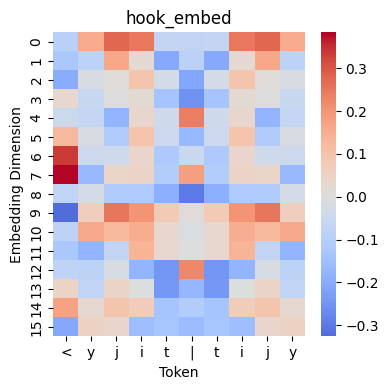

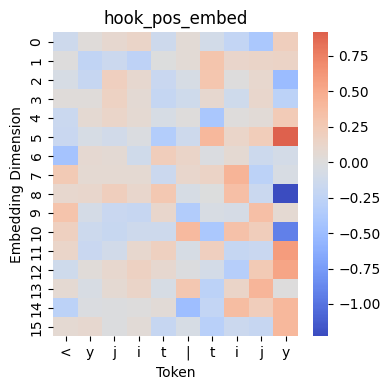

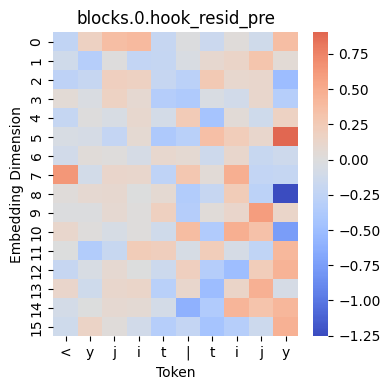

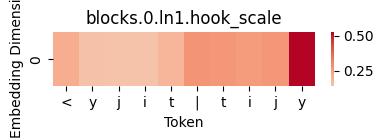

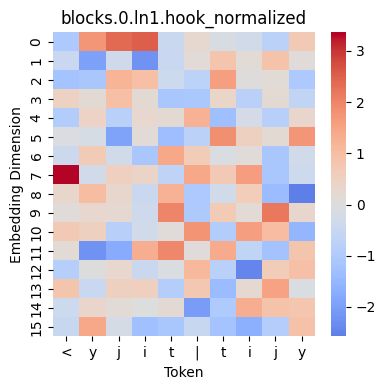

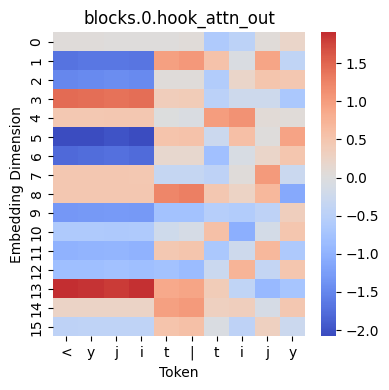

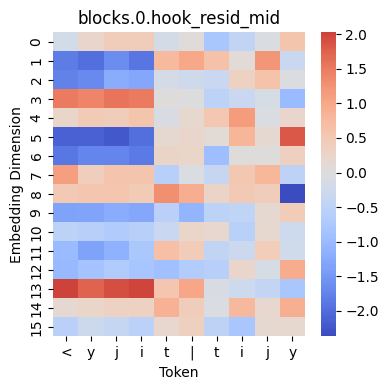

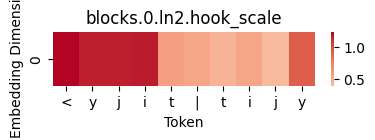

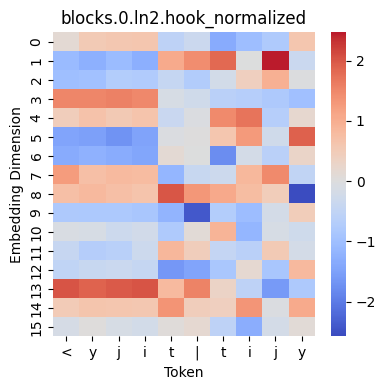

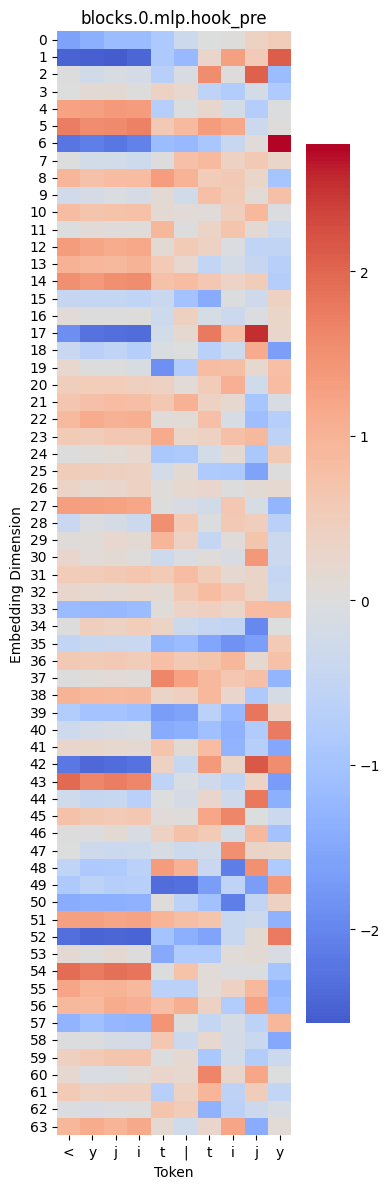

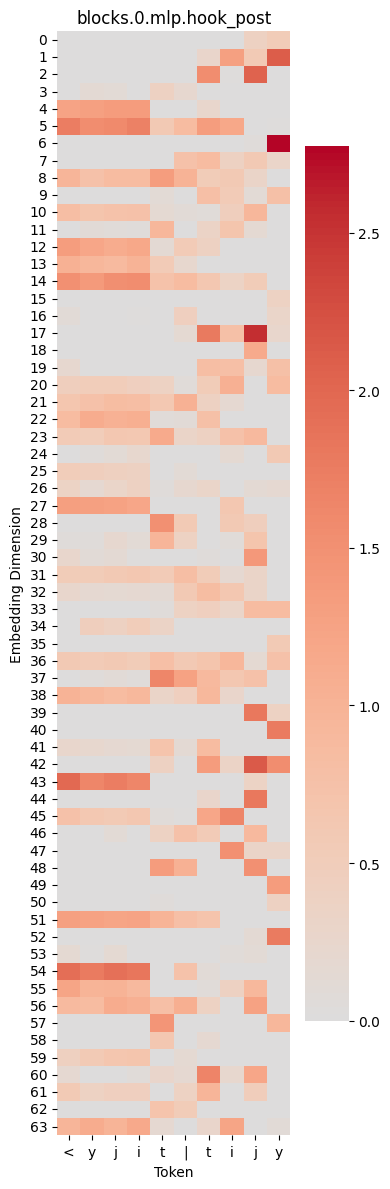

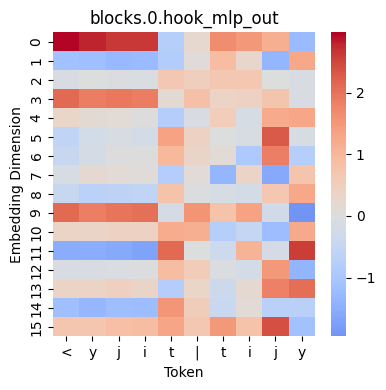

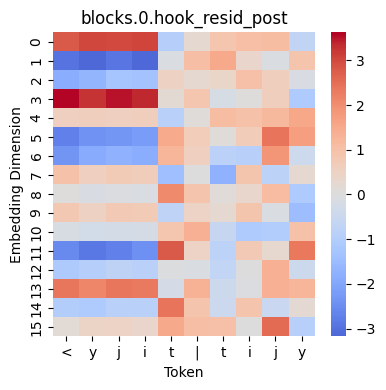

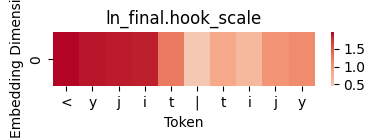

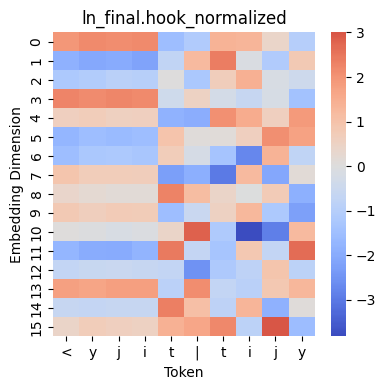

In [35]:
def plot_cache_activation(
    cache: transformer_lens.ActivationCache,
    cache_key: str,
    input_tokens_as_strings: list[str],
) -> None:

    activations = first_batch(cache[cache_key])

    figsize = (4, 4)

    # make figure smaller for vectors
    if activations.shape[-1] == 1:
        figsize = (4, 1.5)

    # for larger activations like MLP, allow it to be taller
    elif activations.shape[-1] > 20:
        figsize = (4, 12)

    plt.figure(figsize=figsize)

    sns.heatmap(
        activations.cpu().numpy().T,
        cmap="coolwarm",
        center=0,
        xticklabels=input_tokens_as_strings,
    )

    plt.title(cache_key)

    # TODO(bschoen): Allow specifying this
    #
    plt.ylabel("Embedding Dimension")
    plt.xlabel("Token")

    plt.tight_layout()
    plt.show()


for cache_key in [
    "hook_embed",
    "hook_pos_embed",
    "blocks.0.hook_resid_pre",
    "blocks.0.ln1.hook_scale",
    "blocks.0.ln1.hook_normalized",
    "blocks.0.hook_attn_out",
    "blocks.0.hook_resid_mid",
    "blocks.0.ln2.hook_scale",
    "blocks.0.ln2.hook_normalized",
    "blocks.0.mlp.hook_pre",
    "blocks.0.mlp.hook_post",
    "blocks.0.hook_mlp_out",
    "blocks.0.hook_resid_post",
    "ln_final.hook_scale",
    "ln_final.hook_normalized",
]:

    plot_cache_activation(
        cache=cache,
        cache_key=cache_key,
        input_tokens_as_strings=input_tokens_as_strings,
    )

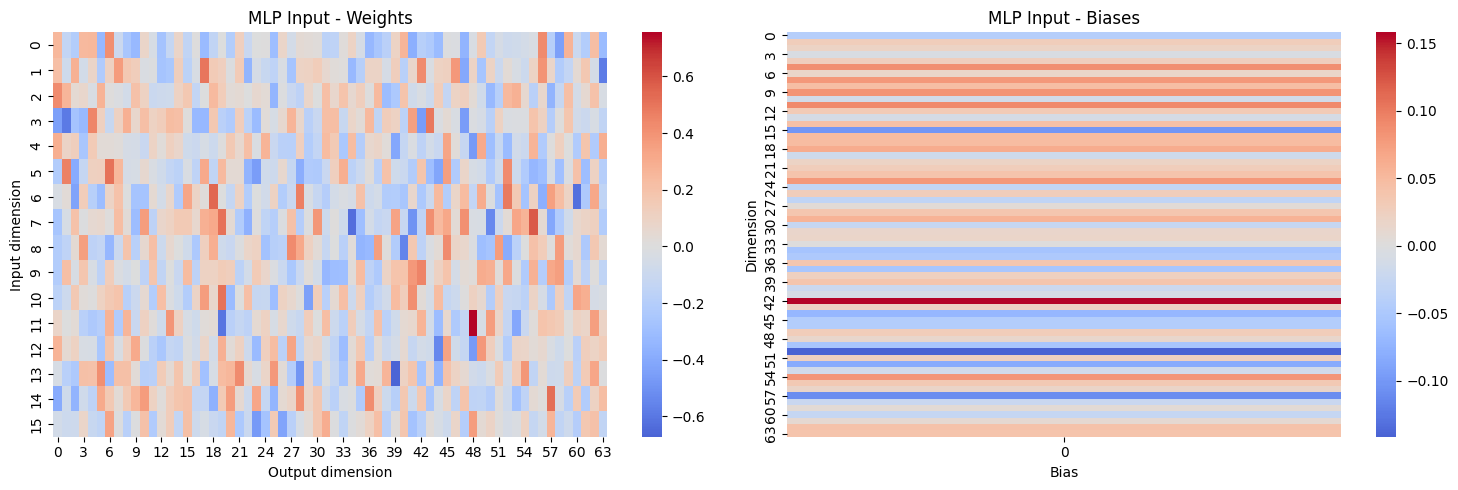

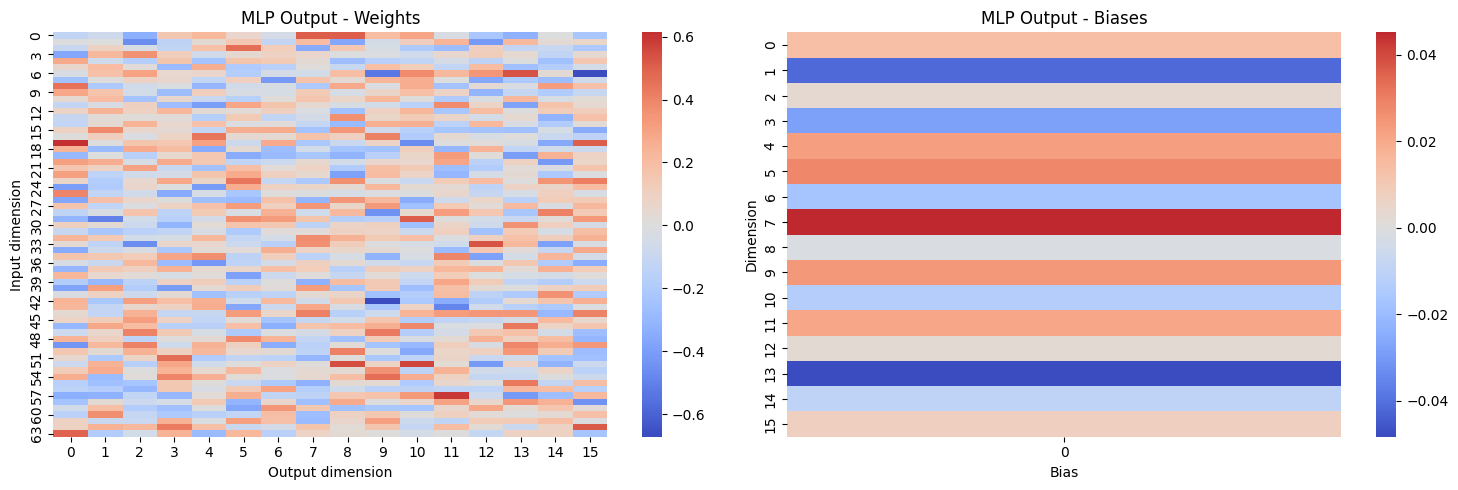

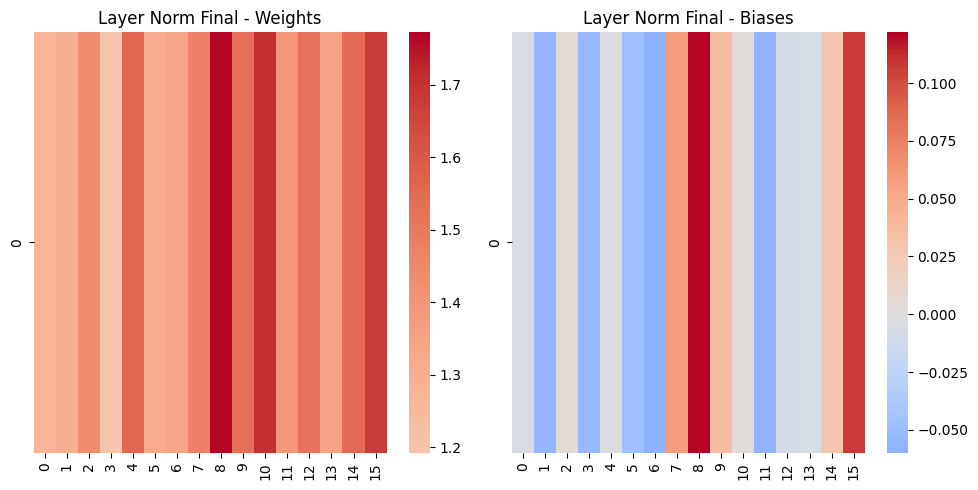

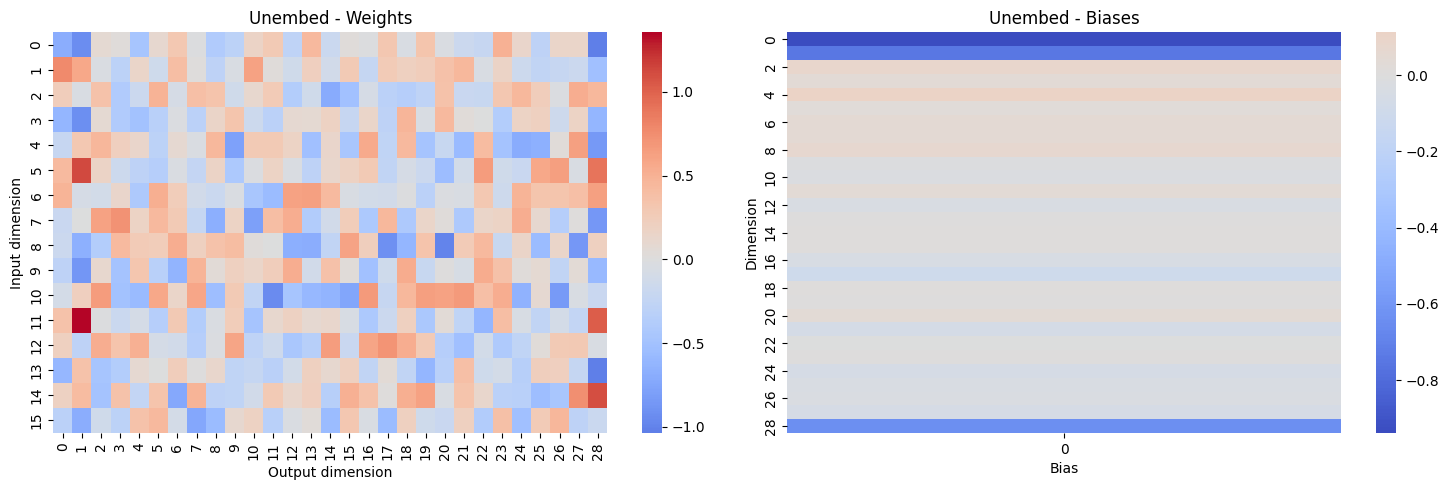

In [36]:
# visualize MLP

import matplotlib.pyplot as plt
import seaborn as sns
import torch


def plot_mlp_weights_and_biases(model):
    # Function to plot heatmaps for MLP weights and biases

    def plot_weight_bias_pair(weight, bias, title):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        sns.heatmap(weight.detach().cpu().numpy(), ax=ax1, cmap="coolwarm", center=0)
        ax1.set_title(f"{title} - Weights")
        ax1.set_xlabel("Output dimension")
        ax1.set_ylabel("Input dimension")

        sns.heatmap(
            bias.detach().cpu().numpy().reshape(-1, 1),
            ax=ax2,
            cmap="coolwarm",
            center=0,
        )
        ax2.set_title(f"{title} - Biases")
        ax2.set_xlabel("Bias")
        ax2.set_ylabel("Dimension")

        plt.tight_layout()
        plt.show()

    # MLP weights and biases
    plot_weight_bias_pair(
        model.blocks[0].mlp.W_in, model.blocks[0].mlp.b_in, "MLP Input"
    )
    plot_weight_bias_pair(
        model.blocks[0].mlp.W_out, model.blocks[0].mlp.b_out, "MLP Output"
    )

    # Layer Norm final
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(
        model.ln_final.w.detach().cpu().numpy().reshape(1, -1),
        cmap="coolwarm",
        center=1,
    )
    plt.title("Layer Norm Final - Weights")
    plt.subplot(1, 2, 2)
    sns.heatmap(
        model.ln_final.b.detach().cpu().numpy().reshape(1, -1),
        cmap="coolwarm",
        center=0,
    )
    plt.title("Layer Norm Final - Biases")
    plt.tight_layout()
    plt.show()

    # Unembed
    plot_weight_bias_pair(model.unembed.W_U, model.unembed.b_U, "Unembed")


# Call the function
plot_mlp_weights_and_biases(model)

# Comment: Additional visualizations that could be useful:
# 1. Histograms of weight/bias distributions
# 2. 3D surface plots for weights to show patterns
# 3. Network architecture diagram with weight magnitudes represented by line thickness
# 4. Animated heatmaps showing weight changes during training

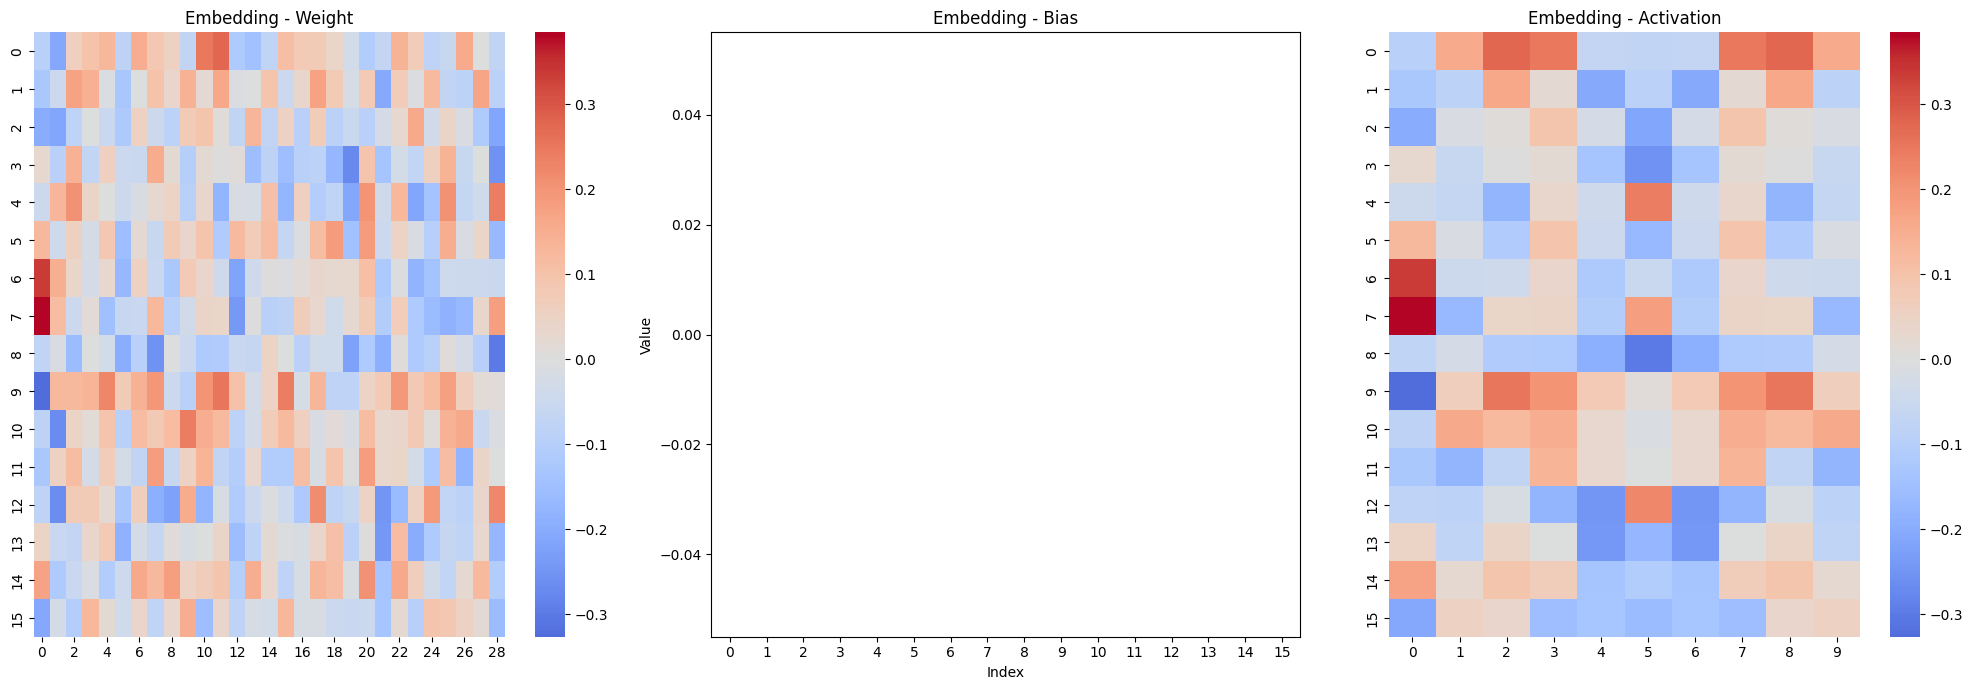

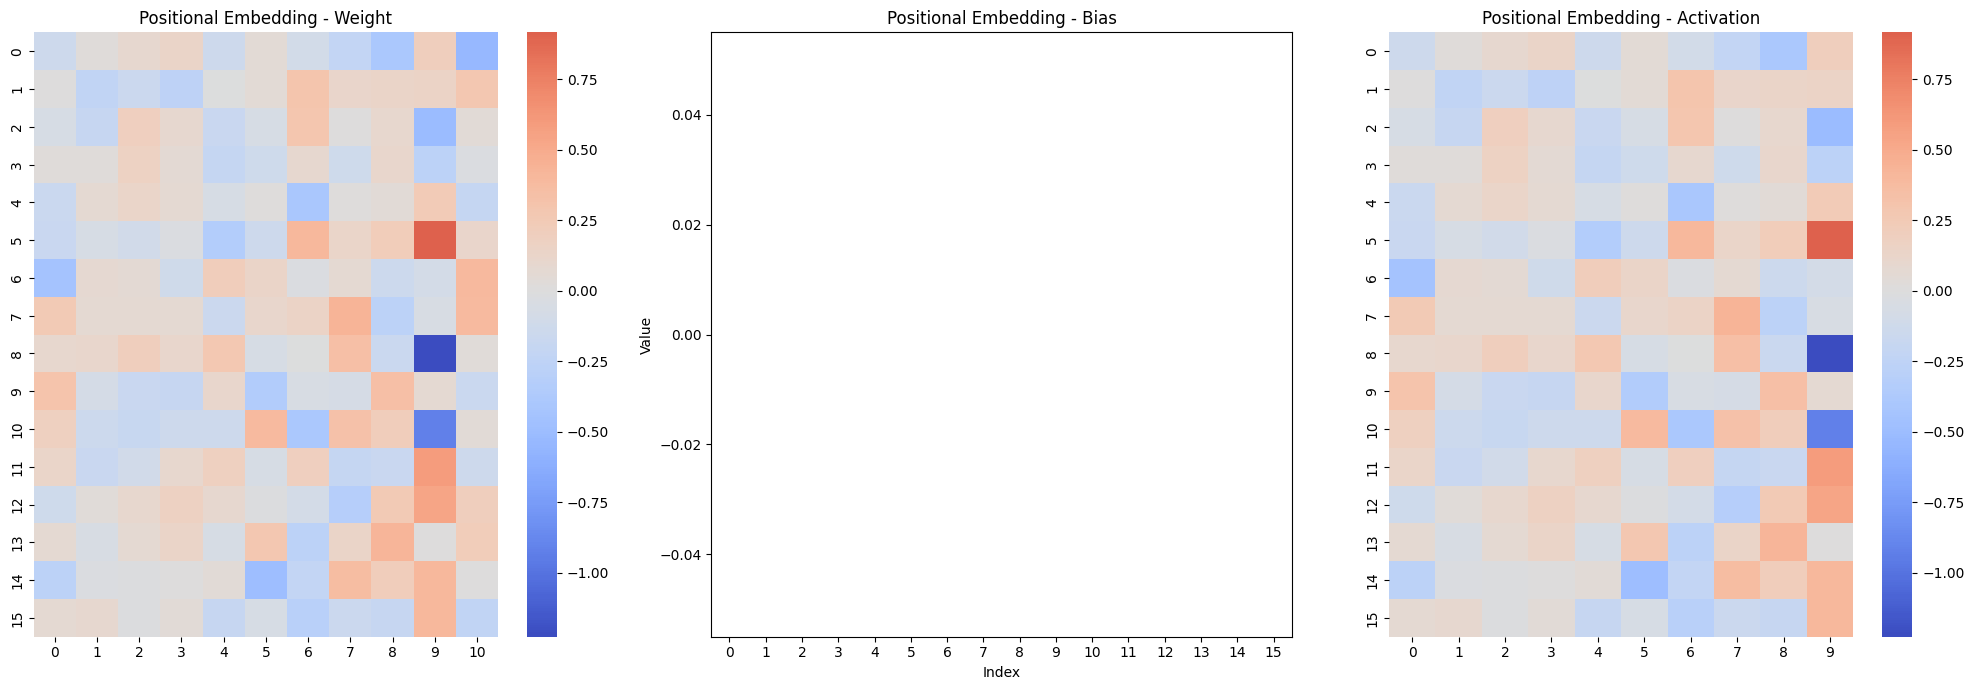

In [37]:
def plot_weight_bias_activation(
    weight,
    bias,
    activation,
    title: str,
) -> None:

    activation = first_batch(activation)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

    sns.heatmap(weight.detach().cpu().numpy().T, ax=ax1, cmap="coolwarm", center=0)
    ax1.set_title(f"{title} - Weight")

    sns.barplot(x=list(range(len(bias))), y=bias.detach().cpu().numpy(), ax=ax2)
    ax2.set_title(f"{title} - Bias")
    ax2.set_xlabel("Index")
    ax2.set_ylabel("Value")

    sns.heatmap(activation.detach().cpu().numpy().T, ax=ax3, cmap="coolwarm", center=0)
    ax3.set_title(f"{title} - Activation")

    plt.tight_layout()
    plt.show()


plot_weight_bias_activation(
    model.embed.W_E,
    torch.zeros(model.embed.W_E.shape[1]),
    cache["hook_embed"],
    "Embedding",
)
plot_weight_bias_activation(
    model.pos_embed.W_pos,
    torch.zeros(model.pos_embed.W_pos.shape[1]),
    cache["hook_pos_embed"],
    "Positional Embedding",
)

In [ ]:
# TODO(bschoen): Hook residual pre?

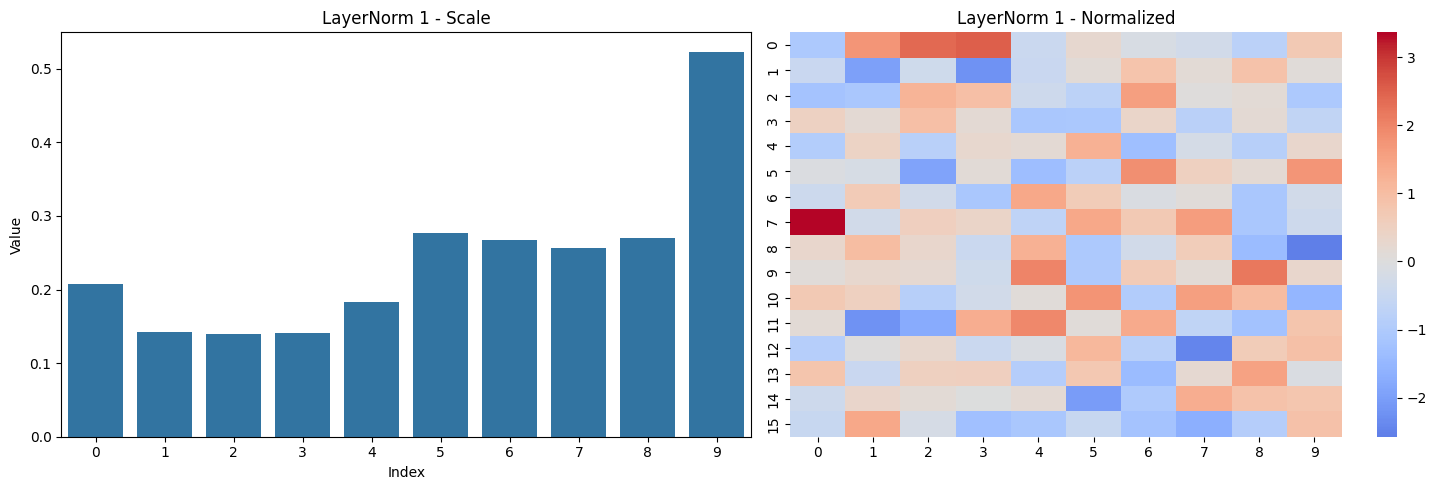

In [38]:
# Plotting LayerNorm components


def plot_layernorm(scale, normalized, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    scale = first_batch(scale)
    normalized = first_batch(normalized)

    sns.barplot(
        x=list(range(len(scale))), y=scale.squeeze().detach().cpu().numpy(), ax=ax1
    )
    ax1.set_title(f"{title} - Scale")
    ax1.set_xlabel("Index")
    ax1.set_ylabel("Value")

    sns.heatmap(normalized.detach().cpu().numpy().T, ax=ax2, cmap="coolwarm", center=0)
    ax2.set_title(f"{title} - Normalized")

    plt.tight_layout()
    plt.show()


plot_layernorm(
    cache["blocks.0.ln1.hook_scale"],
    cache["blocks.0.ln1.hook_normalized"],
    "LayerNorm 1",
)

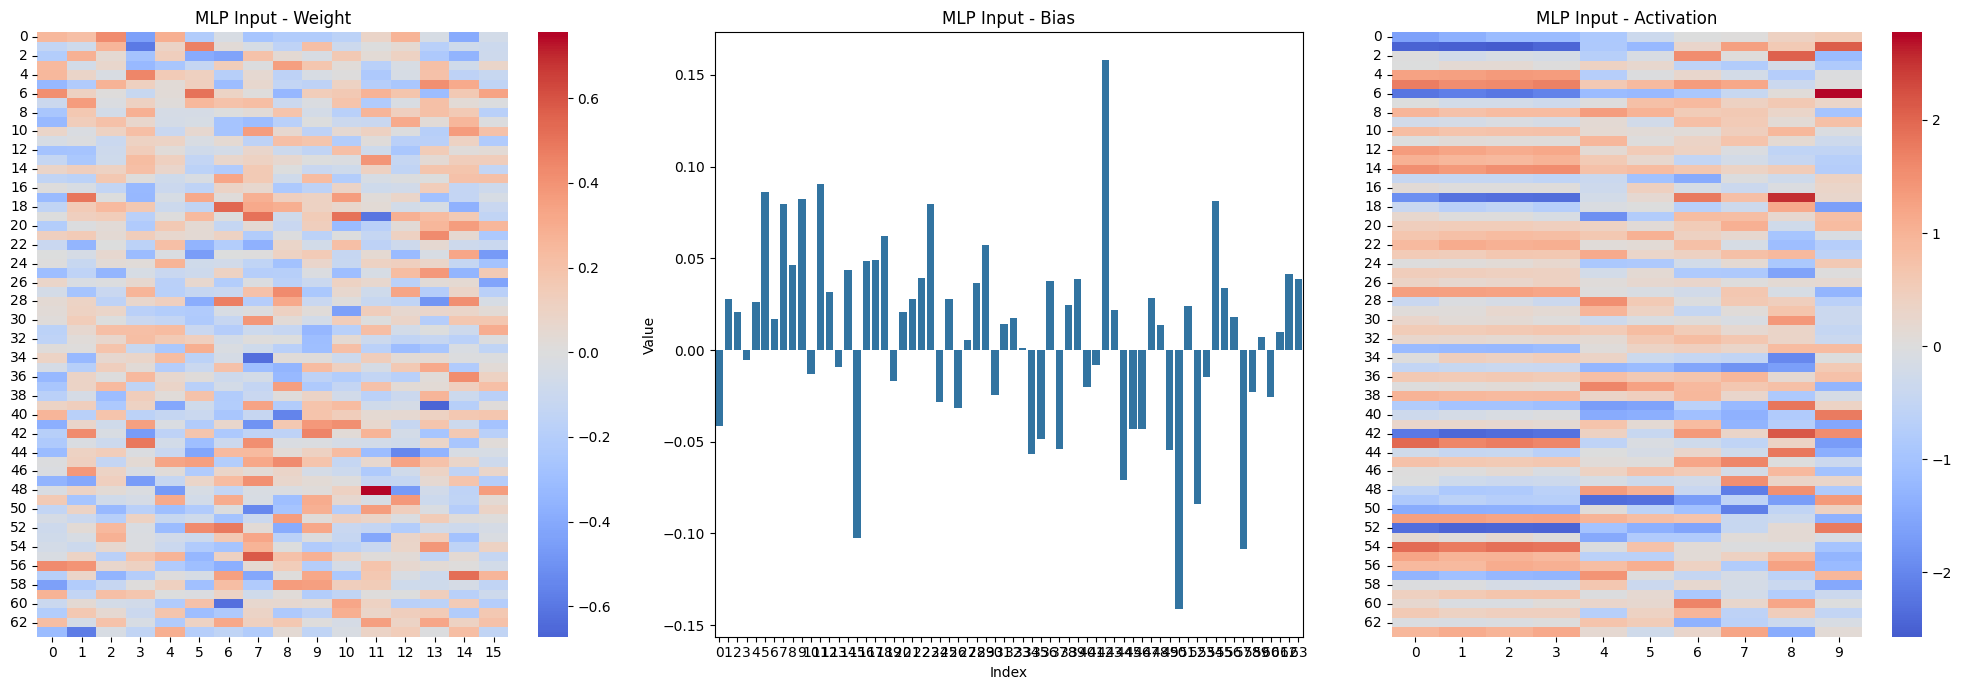

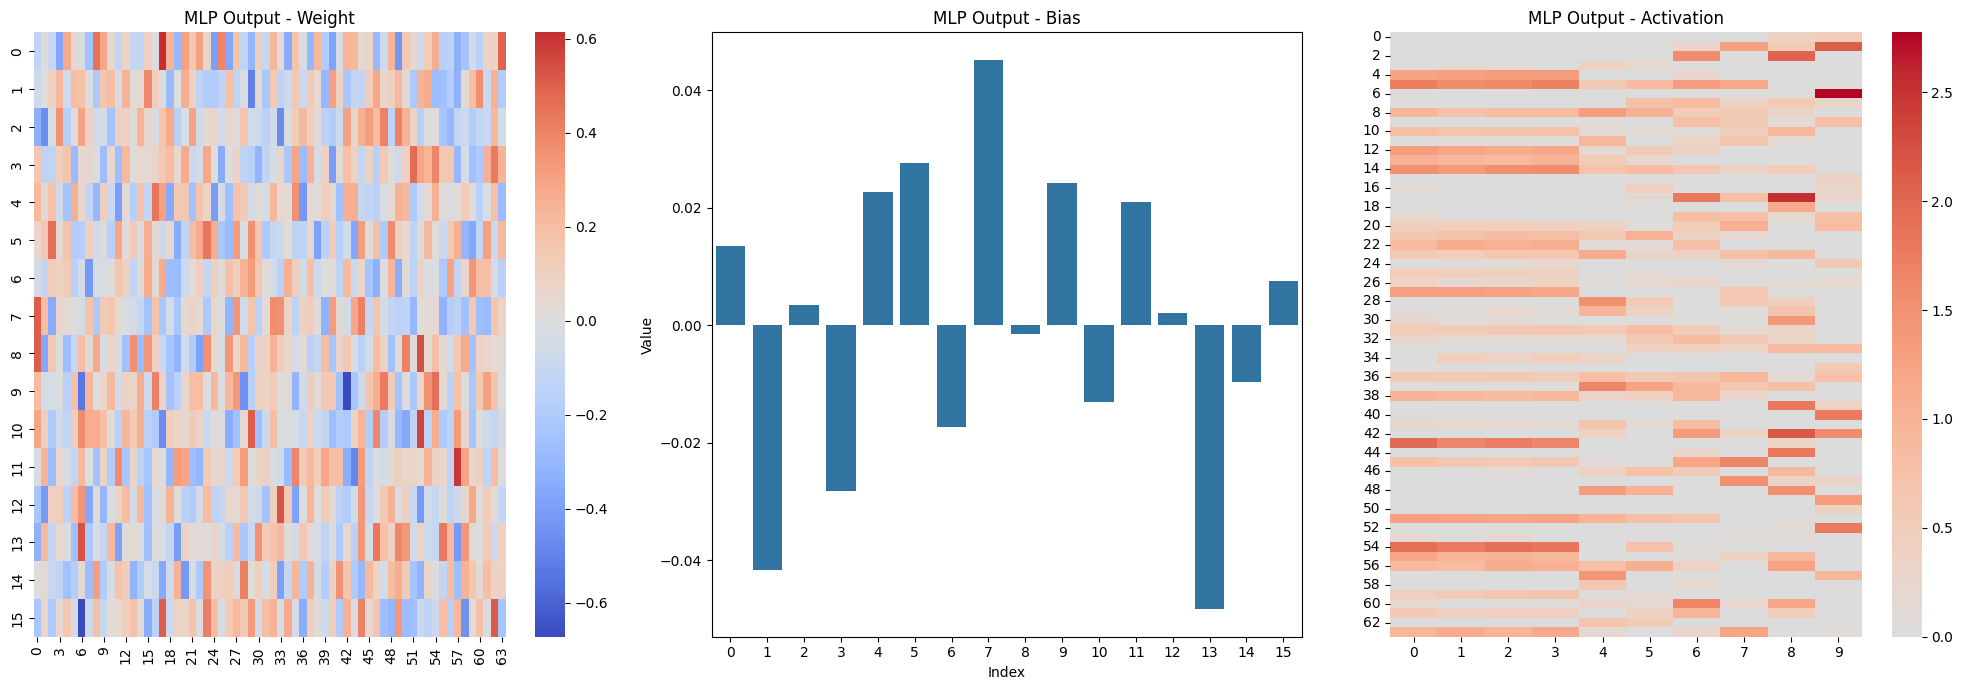

In [39]:
# Plotting MLP components
plot_weight_bias_activation(
    model.blocks[0].mlp.W_in,
    model.blocks[0].mlp.b_in,
    cache["blocks.0.mlp.hook_pre"],
    "MLP Input",
)
plot_weight_bias_activation(
    model.blocks[0].mlp.W_out,
    model.blocks[0].mlp.b_out,
    cache["blocks.0.mlp.hook_post"],
    "MLP Output",
)

#### circuitsvis.activations

In [42]:
# tokens := List of tokens if single sample (e.g. `["A", "person"]`) or list of lists of tokens (e.g. `[[["A", "person"], ["is", "walking"]]]`)
# activations := Activations of the shape [tokens x layers x neurons] if single sample or list of [tokens x layers x neurons] if multiple samples

# take first batch for now
activations = cache["blocks.0.hook_mlp_out"][0]
print(f"{activations.shape=}")

# reshape [tokens x neurons] -> [tokens x 1 x neurons]
#  - `-1` means to automatically infer the size of the last dimension
activations_view = activations.view(len(input_tokens), cfg.n_layers, -1)

print(f"{activations_view.shape=}")

# convert to strings (which this function expects)
input_tokens_as_strings = [token_to_string(x.item()) for x in input_tokens]

# TODO(bschoen): Is there a way to essentially stack these? Claude can probably give the React for that

# so here we can visualize activations for a `torch.Size([1, 8, 16])`, which is most
# of them since this is the size of the embedding dimension
circuitsvis.activations.text_neuron_activations(
    tokens=[token_to_string(x.item()) for x in input_tokens],
    activations=activations_view,
)

activations.shape=torch.Size([10, 16])
activations_view.shape=torch.Size([10, 1, 16])


#### circuitsvis.attention

In [43]:
# tokens: List of tokens (e.g. `["A", "person"]`). Must be the same length as the list of values.
# attention: Attention head activations of the shape [dest_tokens x src_tokens]
# max_value: Maximum value. Used to determine how dark the token color is when positive (i.e. based on how close it is to the maximum value).
# min_value: Minimum value. Used to determine how dark the token color is when negative (i.e. based on how close it is to the minimum value).
# negative_color: Color for negative values
# positive_color: Color for positive values.
# show_axis_labels: Whether to show axis labels.
# mask_upper_tri: Whether or not to mask the upper triangular portion of the attention patterns. Should be true for causal attention, false for bidirectional attention.


# take first batch
# ex: torch.Size([4, 8, 8]) -> [n_heads, n_ctx, n_ctx]
# note: `blocks.0.attn.hook_attn_scores` is too early (not normalized?)
attention = cache["blocks.0.attn.hook_pattern"][0]

print(f"{attention.shape=}")

circuitsvis.attention.attention_heads(
    tokens=input_tokens_as_strings,
    attention=attention,
    max_value=1,
    min_value=-1,
    negative_color="blue",
    positive_color="red",
    mask_upper_tri=True,
)

attention.shape=torch.Size([1, 10, 10])


#### circuitsvis.logits

In [ ]:
# this is the normal one we usually show, i.e.
# cv.logits.token_log_probs(
#     token_indices=input_tokens,
#     log_probs=log_probs,
#     to_string=token_to_string,
# )

#### circuitsvis.tokens

In [44]:
# for example, we'll look at each

# take first batch, ex: torch.Size([8, 16])
pos_embed = cache["hook_pos_embed"][0]

# low level function for coloring tokens according to single value
for i in range(cfg.d_model):
    display(
        circuitsvis.tokens.colored_tokens(
            tokens=input_tokens_as_strings,
            values=pos_embed[:, i],
            negative_color="blue",
            positive_color="red",
        )
    )

    # only display a few for example
    # if i >= 2:
    #    break

In [45]:
# take first batch
# ex: torch.size([8, 16]) = [n_ctx, d_model]
attention_out = cache["blocks.0.hook_attn_out"][0]

circuitsvis.tokens.colored_tokens_multi(
    tokens=input_tokens_as_strings,
    values=attention_out,
    labels=[str(x) for x in range(cfg.d_model)],
)

In [46]:
circuitsvis.tokens.visualize_model_performance(
    tokens=input_tokens,
    str_tokens=input_tokens_as_strings,
    logits=logits,
)

#### circuitsvis.topk_samples

In [ ]:
circuitsvis.topk_samples.topk_samples??

#### circuitsvis.topk_tokens

In [ ]:
circuitsvis.topk_tokens.topk_tokens??

## SAE

In [47]:
for layer_index in range(cfg.n_layers):
    imshow(
        transformer_lens.utils.to_numpy(cache["attn", layer_index].mean([0, 1])),
        title=f"Layer {layer_index} Attention Pattern",
        height=400,
        width=400,
    )

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import dataclasses

Loss = Float32[torch.Tensor, ""]
MSELoss = Float32[torch.Tensor, ""]
WeightedSparsityLoss = Float32[torch.Tensor, ""]

Logits = Float32[torch.Tensor, "n_ctx d_vocab"]
BatchedLogits = Float32[torch.Tensor, "batch n_ctx d_vocab"]

ModelActivations = Float32[torch.Tensor, "n_ctx d_model"]
BatchedModelActivations = Float32[torch.Tensor, "batch n_ctx d_model"]

FlattenedModelActivations = Float32[torch.Tensor, "d_sae_in"]

BatchedFlattenedModelActivations = Float32[torch.Tensor, "batch d_sae_in"]
BatchedSAEActivations = Float32[torch.Tensor, "batch d_sae_model"]


@dataclasses.dataclass
class SAEOutput:
    sae_activations: BatchedSAEActivations
    reconstructed_model_activations: BatchedFlattenedModelActivations


def sparse_loss_kl_divergence(
    flattened_model_activations: BatchedFlattenedModelActivations,
    sae_output: SAEOutput,
    sparsity_target: float,
    sparsity_weight: float,
    epsilon: float = 1e-7,
) -> tuple[Loss, MSELoss, WeightedSparsityLoss]:

    # same as dense loss (this is constant?)
    mse_loss = F.mse_loss(
        sae_output.reconstructed_model_activations,
        flattened_model_activations,
    )

    # KL divergence for sparsity
    avg_activation = torch.mean(sae_output.sae_activations, dim=0)

    # print(f'[pre-clamping] {avg_activation=}')

    # Add epsilon for numerical stability
    avg_activation = torch.clamp(avg_activation, epsilon, 1 - epsilon)

    kl_div = sparsity_target * torch.log(sparsity_target / avg_activation) + (
        1 - sparsity_target
    ) * torch.log((1 - sparsity_target) / (1 - avg_activation))
    kl_div = torch.sum(kl_div)

    # `sparsity_weight` decides how much we weight `KL-Divergence`
    sparsity_penalty = sparsity_weight * kl_div

    # print(f"{mse_loss=}, {avg_activation=}, {kl_div.item()}, {sparsity_penalty=}")

    return mse_loss + sparsity_penalty, mse_loss, sparsity_penalty

In [49]:
def sparse_loss_l1_norm(
    flattened_model_activations: BatchedFlattenedModelActivations,
    sae_output: SAEOutput,
    sparsity_weight: float,
) -> tuple[Loss, MSELoss, WeightedSparsityLoss]:

    # Reconstruction loss (Mean Squared Error)
    mse_loss = F.mse_loss(
        sae_output.reconstructed_model_activations,
        flattened_model_activations,
    )

    # L1 sparsity penalty
    l1_penalty = torch.mean(torch.abs(sae_output.sae_activations))

    sparsity_penalty = sparsity_weight * l1_penalty

    # Total loss
    total_loss = mse_loss + sparsity_penalty

    return total_loss, mse_loss, sparsity_penalty

In [50]:
import dataclasses


@dataclasses.dataclass
class SparseAutoencoderConfig:
    d_in: int
    d_model: int


# TODO(bschoen): Start using the config pattern, it stays typesafe and allows
#                easy logging to things like wandb
class SparseAutoencoder(nn.Module):
    def __init__(
        self,
        cfg: SparseAutoencoderConfig,
    ) -> None:

        print(f"Creating SparseAutoencoder with {cfg}")

        super(SparseAutoencoder, self).__init__()

        self.d_in = cfg.d_in
        self.d_model = cfg.d_model

        self.encoder = nn.Linear(cfg.d_in, cfg.d_model)
        self.decoder = nn.Linear(cfg.d_model, cfg.d_in)

    def forward(
        self,
        x: BatchedFlattenedModelActivations,
    ) -> SAEOutput:

        # TODO(bschoen): Which activation function should we use?
        encoded = F.gelu(self.encoder(x))

        decoded = self.decoder(encoded)

        return SAEOutput(
            sae_activations=encoded,
            reconstructed_model_activations=decoded,
        )

In [51]:
import lightning.pytorch


@dataclasses.dataclass
class LightningSparseAutoencoderConfig:

    model_config: transformer_lens.HookedTransformerConfig
    sae_config: SparseAutoencoderConfig
    learning_rate: float
    sparsity_weight: float


# note: this kind of lightning adapter is a common pattern: https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#starter-example
class LightningSparseAutoencoder(lightning.pytorch.LightningModule):
    def __init__(
        self,
        cfg: LightningSparseAutoencoderConfig,
    ) -> None:

        super(LightningSparseAutoencoder, self).__init__()

        self.model = transformer_lens.HookedTransformer(cfg=cfg.model_config)
        self.sae = SparseAutoencoder(cfg=cfg.sae_config)
        self.cfg = cfg

    def forward(self, inputs, target):
        return self.model(inputs, target)

    def training_step(self, batch, batch_idx: int) -> Loss:
        inputs, target = batch

        self.model
        output = self(inputs, target)
        loss = torch.nn.functional.cr(output, target.view(-1))
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.model.parameters(), lr=0.1)

In [52]:
hook_id = "blocks.0.hook_mlp_out"

cache[hook_id].shape

torch.Size([1, 10, 16])

In [73]:
# Training loop
sae_num_epochs = 100000
sae_expansion_factor = 64

learning_rate = 5e-4

# both arbitrary for now
# - Start small: A common approach is to begin with a relatively small sparsity weight,
#                typically in the range of 1e-5 to 1e-3. This allows the model to
#                learn meaningful representations before enforcing strong sparsity
#                constraints.
sparsity_weight: float = 1e-3  # Weight of the sparsity loss in the total loss
sparsity_target: float = 0.05  # Target average activation of hidden neurons

print(f"Training SAE for {hook_id}...")
sae_d_in = (cfg.n_ctx - 1) * cfg.d_model  # -1 since not predicting first token
sae_d_model = sae_d_in * sae_expansion_factor

sae_cfg = SparseAutoencoderConfig(
    d_in=sae_d_in,
    d_model=sae_d_model,
)

sae_model = SparseAutoencoder(cfg=sae_cfg)
sae_model.to(device)

sae_optimizer = optim.Adam(sae_model.parameters(), lr=learning_rate)

wandb.init(
    project="toy-problem-hooked-transformer-sae",
    config={
        "sae_num_epochs": sae_num_epochs,
        "sae_expansion_factor": sae_expansion_factor,
        "learning_rate": learning_rate,
        "sparsity_weight": sparsity_weight,
        "sparsity_target": sparsity_target,
        "sae_d_in": sae_d_in,
        "sae_d_model": sae_d_model,
        "hook_id": hook_id,
    },
)

# put model itself into eval mode so doesn't change
model.eval()

# go through the training data again, this time training the sae on the activations
for epoch, batch in tqdm.tqdm(
    zip(
        range(sae_num_epochs),
        itertools.cycle(train_loader),
    )
):

    tokens, target = batch

    tokens, target = tokens.to(device), target.to(device)

    # run through the model (with cache) to get the activations
    logits, cache = model.run_with_cache(tokens)

    # ex: torch.Size([4, 8, 16])
    activations = cache[hook_id]

    # ex: torch.Size([4, 128])
    flattened_activations = activations.reshape(activations.size(0), -1)

    sae_optimizer.zero_grad()

    # now the SAE model is given the *activations*
    sae_output = sae_model.forward(flattened_activations)

    # compute loss

    total_loss, reconstruction_loss, weighted_sparsity_loss = sparse_loss_kl_divergence(
        flattened_activations,
        sae_output,
        sparsity_target=sparsity_target,
        sparsity_weight=sparsity_weight,
    )

    """total_loss, reconstruction_loss, weighted_sparsity_loss = sparse_loss_l1_norm(
        flattened_model_activations=flattened_activations,
        sae_output=sae_output,
        sparsity_weight=sparsity_weight,
    )"""

    total_loss.backward()

    sae_optimizer.step()

    if epoch % 500 == 0:
        print(
            f"Step {epoch}, "
            f"Total Loss: {total_loss.item():.6f}, "
            f"Reconstruction Loss: {reconstruction_loss.item():.6f}, "
            f"Sparsity Loss: {weighted_sparsity_loss.item():.6f}",
        )

        wandb.log(
            {
                "epoch": epoch,
                "total_loss": total_loss.item(),
                "reconstruction_loss": reconstruction_loss.item(),
                "weighted_sparsity_loss": weighted_sparsity_loss.item(),
            }
        )

wandb.finish()

Training SAE for blocks.0.hook_mlp_out...
Creating SparseAutoencoder with SparseAutoencoderConfig(d_in=160, d_model=10240)


epoch,▁
reconstruction_loss,▁
total_loss,▁
weighted_sparsity_loss,▁
epoch,0
reconstruction_loss,1.2681
total_loss,9.01368
weighted_sparsity_loss,7.74557


18it [00:00, 92.22it/s]

Step 0, Total Loss: 9.078185, Reconstruction Loss: 1.213749, Sparsity Loss: 7.864436


517it [00:04, 120.44it/s]

Step 500, Total Loss: 2.268156, Reconstruction Loss: 0.000767, Sparsity Loss: 2.267389


1006it [00:09, 87.74it/s]

Step 1000, Total Loss: 2.197196, Reconstruction Loss: 0.000465, Sparsity Loss: 2.196730


1515it [00:13, 123.13it/s]

Step 1500, Total Loss: 2.708572, Reconstruction Loss: 0.000464, Sparsity Loss: 2.708107


2022it [00:17, 123.20it/s]

Step 2000, Total Loss: 3.523380, Reconstruction Loss: 0.000682, Sparsity Loss: 3.522698


2514it [00:22, 117.37it/s]

Step 2500, Total Loss: 4.441718, Reconstruction Loss: 0.000815, Sparsity Loss: 4.440903


3023it [00:26, 119.16it/s]

Step 3000, Total Loss: 5.281950, Reconstruction Loss: 0.000590, Sparsity Loss: 5.281361


3522it [00:30, 114.68it/s]

Step 3500, Total Loss: 5.952341, Reconstruction Loss: 0.000748, Sparsity Loss: 5.951593


4025it [00:35, 119.92it/s]

Step 4000, Total Loss: 6.354052, Reconstruction Loss: 0.000683, Sparsity Loss: 6.353368


4514it [00:39, 119.54it/s]

Step 4500, Total Loss: 6.815797, Reconstruction Loss: 0.000814, Sparsity Loss: 6.814984


5013it [00:43, 92.59it/s] 

Step 5000, Total Loss: 7.158701, Reconstruction Loss: 0.000533, Sparsity Loss: 7.158168


5514it [00:48, 118.73it/s]

Step 5500, Total Loss: 7.509217, Reconstruction Loss: 0.000970, Sparsity Loss: 7.508247


6020it [00:52, 102.84it/s]

Step 6000, Total Loss: 7.902774, Reconstruction Loss: 0.000809, Sparsity Loss: 7.901965


6518it [00:57, 117.58it/s]

Step 6500, Total Loss: 8.047374, Reconstruction Loss: 0.001444, Sparsity Loss: 8.045930


7023it [01:01, 123.00it/s]

Step 7000, Total Loss: 8.135767, Reconstruction Loss: 0.000782, Sparsity Loss: 8.134985


7517it [01:05, 123.16it/s]

Step 7500, Total Loss: 8.026815, Reconstruction Loss: 0.000861, Sparsity Loss: 8.025954


8021it [01:09, 112.97it/s]

Step 8000, Total Loss: 8.059672, Reconstruction Loss: 0.001534, Sparsity Loss: 8.058138


8515it [01:13, 121.91it/s]

Step 8500, Total Loss: 7.868179, Reconstruction Loss: 0.001214, Sparsity Loss: 7.866965


9017it [01:17, 97.22it/s] 

Step 9000, Total Loss: 7.577255, Reconstruction Loss: 0.000802, Sparsity Loss: 7.576453


9519it [01:22, 118.24it/s]

Step 9500, Total Loss: 7.202765, Reconstruction Loss: 0.000998, Sparsity Loss: 7.201766


10017it [01:26, 117.16it/s]

Step 10000, Total Loss: 6.702085, Reconstruction Loss: 0.000991, Sparsity Loss: 6.701094


10524it [01:30, 114.70it/s]

Step 10500, Total Loss: 6.267054, Reconstruction Loss: 0.001123, Sparsity Loss: 6.265931


11016it [01:35, 107.67it/s]

Step 11000, Total Loss: 5.952898, Reconstruction Loss: 0.001170, Sparsity Loss: 5.951727


11517it [01:39, 117.80it/s]

Step 11500, Total Loss: 5.665514, Reconstruction Loss: 0.001203, Sparsity Loss: 5.664311


12013it [01:43, 117.84it/s]

Step 12000, Total Loss: 5.309026, Reconstruction Loss: 0.001381, Sparsity Loss: 5.307645


12513it [01:48, 115.30it/s]

Step 12500, Total Loss: 5.025174, Reconstruction Loss: 0.001269, Sparsity Loss: 5.023905


13018it [01:52, 114.70it/s]

Step 13000, Total Loss: 4.653657, Reconstruction Loss: 0.002121, Sparsity Loss: 4.651536


13518it [01:57, 109.26it/s]

Step 13500, Total Loss: 4.429592, Reconstruction Loss: 0.001089, Sparsity Loss: 4.428502


14020it [02:01, 117.35it/s]

Step 14000, Total Loss: 4.077754, Reconstruction Loss: 0.001643, Sparsity Loss: 4.076111


14519it [02:05, 110.06it/s]

Step 14500, Total Loss: 3.856755, Reconstruction Loss: 0.001203, Sparsity Loss: 3.855551


15019it [02:10, 114.37it/s]

Step 15000, Total Loss: 3.486136, Reconstruction Loss: 0.001116, Sparsity Loss: 3.485020


15521it [02:14, 122.22it/s]

Step 15500, Total Loss: 3.265593, Reconstruction Loss: 0.001611, Sparsity Loss: 3.263982


16013it [02:18, 120.80it/s]

Step 16000, Total Loss: 3.012486, Reconstruction Loss: 0.001529, Sparsity Loss: 3.010957


16518it [02:22, 122.50it/s]

Step 16500, Total Loss: 2.904397, Reconstruction Loss: 0.001287, Sparsity Loss: 2.903110


17022it [02:27, 122.75it/s]

Step 17000, Total Loss: 2.793407, Reconstruction Loss: 0.001134, Sparsity Loss: 2.792273


17518it [02:31, 91.01it/s] 

Step 17500, Total Loss: 2.771902, Reconstruction Loss: 0.001218, Sparsity Loss: 2.770684


18021it [02:36, 118.20it/s]

Step 18000, Total Loss: 2.666683, Reconstruction Loss: 0.001093, Sparsity Loss: 2.665590


18519it [02:40, 116.06it/s]

Step 18500, Total Loss: 2.629408, Reconstruction Loss: 0.001474, Sparsity Loss: 2.627935


19021it [02:44, 117.07it/s]

Step 19000, Total Loss: 2.543168, Reconstruction Loss: 0.001465, Sparsity Loss: 2.541703


19514it [02:48, 119.71it/s]

Step 19500, Total Loss: 2.562552, Reconstruction Loss: 0.001152, Sparsity Loss: 2.561399


20017it [02:53, 102.15it/s]

Step 20000, Total Loss: 2.508954, Reconstruction Loss: 0.001120, Sparsity Loss: 2.507834


20522it [02:59, 106.73it/s]

Step 20500, Total Loss: 2.486243, Reconstruction Loss: 0.001396, Sparsity Loss: 2.484847


21018it [03:04, 117.88it/s]

Step 21000, Total Loss: 2.322782, Reconstruction Loss: 0.001027, Sparsity Loss: 2.321755


21515it [03:08, 116.31it/s]

Step 21500, Total Loss: 2.360887, Reconstruction Loss: 0.001388, Sparsity Loss: 2.359499


22011it [03:13, 96.10it/s] 

Step 22000, Total Loss: 2.393600, Reconstruction Loss: 0.001091, Sparsity Loss: 2.392509


22508it [03:18, 84.01it/s]

Step 22500, Total Loss: 2.368567, Reconstruction Loss: 0.001433, Sparsity Loss: 2.367134


23015it [03:24, 125.46it/s]

Step 23000, Total Loss: 2.332011, Reconstruction Loss: 0.001276, Sparsity Loss: 2.330734


23522it [03:28, 111.37it/s]

Step 23500, Total Loss: 2.244555, Reconstruction Loss: 0.000961, Sparsity Loss: 2.243594


24019it [03:32, 121.97it/s]

Step 24000, Total Loss: 2.294554, Reconstruction Loss: 0.001268, Sparsity Loss: 2.293286


24520it [03:37, 91.30it/s] 

Step 24500, Total Loss: 2.247388, Reconstruction Loss: 0.001226, Sparsity Loss: 2.246162


25018it [03:43, 93.53it/s]

Step 25000, Total Loss: 2.267522, Reconstruction Loss: 0.000994, Sparsity Loss: 2.266528


25516it [03:47, 122.00it/s]

Step 25500, Total Loss: 2.203794, Reconstruction Loss: 0.000987, Sparsity Loss: 2.202807


26015it [03:52, 120.64it/s]

Step 26000, Total Loss: 2.192402, Reconstruction Loss: 0.000884, Sparsity Loss: 2.191518


26520it [03:56, 121.95it/s]

Step 26500, Total Loss: 2.155900, Reconstruction Loss: 0.001009, Sparsity Loss: 2.154891


27014it [04:00, 121.82it/s]

Step 27000, Total Loss: 2.159327, Reconstruction Loss: 0.001109, Sparsity Loss: 2.158218


27519it [04:04, 120.16it/s]

Step 27500, Total Loss: 2.122336, Reconstruction Loss: 0.000859, Sparsity Loss: 2.121477


28012it [04:09, 75.37it/s] 

Step 28000, Total Loss: 2.114047, Reconstruction Loss: 0.001080, Sparsity Loss: 2.112966


28519it [04:14, 102.02it/s]

Step 28500, Total Loss: 2.118881, Reconstruction Loss: 0.001111, Sparsity Loss: 2.117771


29018it [04:18, 109.18it/s]

Step 29000, Total Loss: 2.203649, Reconstruction Loss: 0.001085, Sparsity Loss: 2.202565


29515it [04:22, 122.68it/s]

Step 29500, Total Loss: 2.202141, Reconstruction Loss: 0.001153, Sparsity Loss: 2.200987


30019it [04:26, 123.28it/s]

Step 30000, Total Loss: 2.191681, Reconstruction Loss: 0.000811, Sparsity Loss: 2.190869


30525it [04:31, 123.43it/s]

Step 30500, Total Loss: 2.186988, Reconstruction Loss: 0.001093, Sparsity Loss: 2.185894


31019it [04:35, 124.54it/s]

Step 31000, Total Loss: 2.198886, Reconstruction Loss: 0.000753, Sparsity Loss: 2.198133


31523it [04:39, 122.69it/s]

Step 31500, Total Loss: 2.140435, Reconstruction Loss: 0.001037, Sparsity Loss: 2.139397


32014it [04:44, 124.89it/s]

Step 32000, Total Loss: 2.021830, Reconstruction Loss: 0.000836, Sparsity Loss: 2.020994


32523it [04:48, 112.42it/s]

Step 32500, Total Loss: 2.009063, Reconstruction Loss: 0.000828, Sparsity Loss: 2.008235


33016it [04:53, 112.65it/s]

Step 33000, Total Loss: 1.972517, Reconstruction Loss: 0.000855, Sparsity Loss: 1.971662


33524it [04:57, 114.92it/s]

Step 33500, Total Loss: 1.990781, Reconstruction Loss: 0.001114, Sparsity Loss: 1.989668


34019it [05:01, 119.39it/s]

Step 34000, Total Loss: 1.970920, Reconstruction Loss: 0.000953, Sparsity Loss: 1.969967


34515it [05:06, 119.21it/s]

Step 34500, Total Loss: 1.888324, Reconstruction Loss: 0.000934, Sparsity Loss: 1.887390


35017it [05:10, 117.86it/s]

Step 35000, Total Loss: 1.825279, Reconstruction Loss: 0.000922, Sparsity Loss: 1.824358


35516it [05:14, 113.70it/s]

Step 35500, Total Loss: 1.788982, Reconstruction Loss: 0.000855, Sparsity Loss: 1.788127


36015it [05:19, 117.35it/s]

Step 36000, Total Loss: 1.787198, Reconstruction Loss: 0.000887, Sparsity Loss: 1.786311


36519it [05:24, 114.99it/s]

Step 36500, Total Loss: 1.756738, Reconstruction Loss: 0.000773, Sparsity Loss: 1.755964


37016it [05:28, 116.57it/s]

Step 37000, Total Loss: 1.773340, Reconstruction Loss: 0.000944, Sparsity Loss: 1.772396


37520it [05:33, 116.39it/s]

Step 37500, Total Loss: 1.828177, Reconstruction Loss: 0.000869, Sparsity Loss: 1.827308


38018it [05:37, 103.49it/s]

Step 38000, Total Loss: 1.821995, Reconstruction Loss: 0.000788, Sparsity Loss: 1.821207


38521it [05:42, 121.15it/s]

Step 38500, Total Loss: 1.742209, Reconstruction Loss: 0.000938, Sparsity Loss: 1.741271


39014it [05:46, 120.56it/s]

Step 39000, Total Loss: 1.770384, Reconstruction Loss: 0.000767, Sparsity Loss: 1.769618


39513it [05:50, 111.19it/s]

Step 39500, Total Loss: 1.651608, Reconstruction Loss: 0.000748, Sparsity Loss: 1.650860


40013it [05:54, 115.99it/s]

Step 40000, Total Loss: 1.574810, Reconstruction Loss: 0.000747, Sparsity Loss: 1.574063


40516it [05:59, 122.74it/s]

Step 40500, Total Loss: 1.590797, Reconstruction Loss: 0.000887, Sparsity Loss: 1.589910


41015it [06:03, 119.27it/s]

Step 41000, Total Loss: 1.619598, Reconstruction Loss: 0.000880, Sparsity Loss: 1.618718


41519it [06:07, 116.95it/s]

Step 41500, Total Loss: 1.556440, Reconstruction Loss: 0.000899, Sparsity Loss: 1.555541


42017it [06:12, 118.50it/s]

Step 42000, Total Loss: 1.504524, Reconstruction Loss: 0.000757, Sparsity Loss: 1.503767


42519it [06:16, 110.76it/s]

Step 42500, Total Loss: 1.454425, Reconstruction Loss: 0.000743, Sparsity Loss: 1.453682


43022it [06:21, 119.17it/s]

Step 43000, Total Loss: 1.436381, Reconstruction Loss: 0.000631, Sparsity Loss: 1.435750


43523it [06:25, 115.94it/s]

Step 43500, Total Loss: 1.392123, Reconstruction Loss: 0.000687, Sparsity Loss: 1.391436


44011it [06:31, 86.19it/s] 

Step 44000, Total Loss: 1.434023, Reconstruction Loss: 0.000787, Sparsity Loss: 1.433237


44516it [06:36, 94.86it/s]

Step 44500, Total Loss: 1.502327, Reconstruction Loss: 0.000777, Sparsity Loss: 1.501550


45014it [06:41, 120.79it/s]

Step 45000, Total Loss: 1.518852, Reconstruction Loss: 0.000583, Sparsity Loss: 1.518270


45526it [06:45, 118.06it/s]

Step 45500, Total Loss: 1.521313, Reconstruction Loss: 0.000726, Sparsity Loss: 1.520587


45999it [06:50, 108.70it/s]

Step 46000, Total Loss: 1.486875, Reconstruction Loss: 0.000743, Sparsity Loss: 1.486132


46513it [06:54, 118.98it/s]

Step 46500, Total Loss: 1.500018, Reconstruction Loss: 0.000681, Sparsity Loss: 1.499338


47014it [07:00, 110.50it/s]

Step 47000, Total Loss: 1.442904, Reconstruction Loss: 0.000785, Sparsity Loss: 1.442119


47521it [07:05, 109.87it/s]

Step 47500, Total Loss: 1.399988, Reconstruction Loss: 0.000777, Sparsity Loss: 1.399211


48003it [07:10, 95.72it/s] 

Step 48000, Total Loss: 1.387700, Reconstruction Loss: 0.000597, Sparsity Loss: 1.387103


48521it [07:15, 104.00it/s]

Step 48500, Total Loss: 1.374068, Reconstruction Loss: 0.000564, Sparsity Loss: 1.373504


49016it [07:19, 104.43it/s]

Step 49000, Total Loss: 1.353877, Reconstruction Loss: 0.000765, Sparsity Loss: 1.353113


49514it [07:24, 120.64it/s]

Step 49500, Total Loss: 1.378384, Reconstruction Loss: 0.000694, Sparsity Loss: 1.377689


50024it [07:28, 119.78it/s]

Step 50000, Total Loss: 1.362564, Reconstruction Loss: 0.000564, Sparsity Loss: 1.362000


50514it [07:32, 121.03it/s]

Step 50500, Total Loss: 1.332820, Reconstruction Loss: 0.000626, Sparsity Loss: 1.332194


51019it [07:36, 118.20it/s]

Step 51000, Total Loss: 1.321723, Reconstruction Loss: 0.000499, Sparsity Loss: 1.321224


51521it [07:41, 119.50it/s]

Step 51500, Total Loss: 1.263339, Reconstruction Loss: 0.000739, Sparsity Loss: 1.262600


52017it [07:45, 119.82it/s]

Step 52000, Total Loss: 1.315602, Reconstruction Loss: 0.000869, Sparsity Loss: 1.314734


52518it [07:49, 117.50it/s]

Step 52500, Total Loss: 1.290314, Reconstruction Loss: 0.000942, Sparsity Loss: 1.289372


53017it [07:54, 118.35it/s]

Step 53000, Total Loss: 1.287687, Reconstruction Loss: 0.000580, Sparsity Loss: 1.287107


53521it [07:58, 119.58it/s]

Step 53500, Total Loss: 1.286499, Reconstruction Loss: 0.000574, Sparsity Loss: 1.285925


54023it [08:02, 121.41it/s]

Step 54000, Total Loss: 1.331388, Reconstruction Loss: 0.000628, Sparsity Loss: 1.330760


54513it [08:07, 66.80it/s] 

Step 54500, Total Loss: 1.287620, Reconstruction Loss: 0.000734, Sparsity Loss: 1.286886


55012it [08:12, 110.69it/s]

Step 55000, Total Loss: 1.300889, Reconstruction Loss: 0.000746, Sparsity Loss: 1.300143


55523it [08:16, 116.37it/s]

Step 55500, Total Loss: 1.283752, Reconstruction Loss: 0.001199, Sparsity Loss: 1.282553


56025it [08:21, 113.27it/s]

Step 56000, Total Loss: 1.318360, Reconstruction Loss: 0.000472, Sparsity Loss: 1.317888


56518it [08:26, 117.94it/s]

Step 56500, Total Loss: 1.311814, Reconstruction Loss: 0.000553, Sparsity Loss: 1.311261


57010it [08:31, 97.02it/s] 

Step 57000, Total Loss: 1.315724, Reconstruction Loss: 0.000608, Sparsity Loss: 1.315115


57514it [08:35, 116.71it/s]

Step 57500, Total Loss: 1.256766, Reconstruction Loss: 0.000801, Sparsity Loss: 1.255965


58017it [08:40, 123.43it/s]

Step 58000, Total Loss: 1.254403, Reconstruction Loss: 0.000517, Sparsity Loss: 1.253886


58523it [08:44, 121.76it/s]

Step 58500, Total Loss: 1.272092, Reconstruction Loss: 0.000561, Sparsity Loss: 1.271531


59020it [08:48, 113.24it/s]

Step 59000, Total Loss: 1.256201, Reconstruction Loss: 0.000569, Sparsity Loss: 1.255632


59515it [08:53, 108.72it/s]

Step 59500, Total Loss: 1.209830, Reconstruction Loss: 0.000504, Sparsity Loss: 1.209326


60017it [08:57, 73.90it/s] 

Step 60000, Total Loss: 1.195009, Reconstruction Loss: 0.000649, Sparsity Loss: 1.194360


60514it [09:02, 95.49it/s] 

Step 60500, Total Loss: 1.206911, Reconstruction Loss: 0.000637, Sparsity Loss: 1.206274


61011it [09:07, 94.09it/s] 

Step 61000, Total Loss: 1.179912, Reconstruction Loss: 0.000618, Sparsity Loss: 1.179294


61513it [09:12, 88.43it/s] 

Step 61500, Total Loss: 1.169314, Reconstruction Loss: 0.000633, Sparsity Loss: 1.168681


62011it [09:18, 94.65it/s] 

Step 62000, Total Loss: 1.148385, Reconstruction Loss: 0.000534, Sparsity Loss: 1.147851


62522it [09:22, 119.00it/s]

Step 62500, Total Loss: 1.133248, Reconstruction Loss: 0.000501, Sparsity Loss: 1.132747


63013it [09:27, 105.57it/s]

Step 63000, Total Loss: 1.133279, Reconstruction Loss: 0.000612, Sparsity Loss: 1.132667


63513it [09:32, 114.90it/s]

Step 63500, Total Loss: 1.124782, Reconstruction Loss: 0.000638, Sparsity Loss: 1.124144


64024it [09:36, 114.99it/s]

Step 64000, Total Loss: 1.120936, Reconstruction Loss: 0.000587, Sparsity Loss: 1.120348


64504it [09:41, 102.92it/s]

Step 64500, Total Loss: 1.104320, Reconstruction Loss: 0.000615, Sparsity Loss: 1.103706


65016it [09:46, 107.23it/s]

Step 65000, Total Loss: 1.103258, Reconstruction Loss: 0.000533, Sparsity Loss: 1.102725


65514it [09:50, 100.31it/s]

Step 65500, Total Loss: 1.077880, Reconstruction Loss: 0.000598, Sparsity Loss: 1.077282


66016it [09:55, 105.72it/s]

Step 66000, Total Loss: 1.076210, Reconstruction Loss: 0.000578, Sparsity Loss: 1.075631


66517it [10:00, 119.72it/s]

Step 66500, Total Loss: 1.107769, Reconstruction Loss: 0.000496, Sparsity Loss: 1.107273


67010it [10:04, 103.90it/s]

Step 67000, Total Loss: 1.049184, Reconstruction Loss: 0.000421, Sparsity Loss: 1.048763


67514it [10:09, 114.48it/s]

Step 67500, Total Loss: 1.062258, Reconstruction Loss: 0.000595, Sparsity Loss: 1.061663


68022it [10:13, 113.35it/s]

Step 68000, Total Loss: 1.048063, Reconstruction Loss: 0.000422, Sparsity Loss: 1.047641


68515it [10:18, 115.82it/s]

Step 68500, Total Loss: 1.064043, Reconstruction Loss: 0.000435, Sparsity Loss: 1.063608


69018it [10:22, 118.21it/s]

Step 69000, Total Loss: 1.046156, Reconstruction Loss: 0.000592, Sparsity Loss: 1.045564


69520it [10:26, 119.84it/s]

Step 69500, Total Loss: 1.045489, Reconstruction Loss: 0.000480, Sparsity Loss: 1.045009


70020it [10:31, 119.77it/s]

Step 70000, Total Loss: 1.030158, Reconstruction Loss: 0.000455, Sparsity Loss: 1.029703


70524it [10:35, 119.11it/s]

Step 70500, Total Loss: 1.033111, Reconstruction Loss: 0.000459, Sparsity Loss: 1.032652


71019it [10:39, 92.86it/s] 

Step 71000, Total Loss: 1.029167, Reconstruction Loss: 0.000393, Sparsity Loss: 1.028775


71522it [10:44, 119.26it/s]

Step 71500, Total Loss: 1.031121, Reconstruction Loss: 0.000570, Sparsity Loss: 1.030550


72013it [10:48, 117.90it/s]

Step 72000, Total Loss: 1.028361, Reconstruction Loss: 0.000490, Sparsity Loss: 1.027871


72521it [10:52, 126.86it/s]

Step 72500, Total Loss: 0.985636, Reconstruction Loss: 0.000483, Sparsity Loss: 0.985153


73013it [10:56, 117.93it/s]

Step 73000, Total Loss: 1.029794, Reconstruction Loss: 0.000503, Sparsity Loss: 1.029290


73524it [11:01, 107.10it/s]

Step 73500, Total Loss: 1.015835, Reconstruction Loss: 0.000374, Sparsity Loss: 1.015461


74015it [11:06, 113.40it/s]

Step 74000, Total Loss: 1.002014, Reconstruction Loss: 0.000533, Sparsity Loss: 1.001480


74516it [11:11, 86.93it/s] 

Step 74500, Total Loss: 0.986266, Reconstruction Loss: 0.000585, Sparsity Loss: 0.985681


75020it [11:16, 98.45it/s] 

Step 75000, Total Loss: 0.957711, Reconstruction Loss: 0.000463, Sparsity Loss: 0.957248


75515it [11:21, 109.84it/s]

Step 75500, Total Loss: 0.926570, Reconstruction Loss: 0.000445, Sparsity Loss: 0.926126


76027it [11:25, 126.58it/s]

Step 76000, Total Loss: 0.941309, Reconstruction Loss: 0.000459, Sparsity Loss: 0.940850


76517it [11:29, 121.47it/s]

Step 76500, Total Loss: 0.926413, Reconstruction Loss: 0.000415, Sparsity Loss: 0.925997


77015it [11:34, 117.48it/s]

Step 77000, Total Loss: 0.925774, Reconstruction Loss: 0.000452, Sparsity Loss: 0.925322


77520it [11:38, 107.36it/s]

Step 77500, Total Loss: 0.941816, Reconstruction Loss: 0.000492, Sparsity Loss: 0.941325


78013it [11:43, 115.41it/s]

Step 78000, Total Loss: 0.936487, Reconstruction Loss: 0.000551, Sparsity Loss: 0.935936


78518it [11:47, 108.27it/s]

Step 78500, Total Loss: 0.938454, Reconstruction Loss: 0.000501, Sparsity Loss: 0.937953


79021it [11:52, 108.95it/s]

Step 79000, Total Loss: 0.941157, Reconstruction Loss: 0.000437, Sparsity Loss: 0.940720


79514it [11:57, 117.62it/s]

Step 79500, Total Loss: 0.958044, Reconstruction Loss: 0.000371, Sparsity Loss: 0.957672


80018it [12:02, 111.54it/s]

Step 80000, Total Loss: 0.954283, Reconstruction Loss: 0.000446, Sparsity Loss: 0.953837


80515it [12:07, 91.45it/s] 

Step 80500, Total Loss: 0.969696, Reconstruction Loss: 0.000423, Sparsity Loss: 0.969273


81014it [12:12, 114.93it/s]

Step 81000, Total Loss: 0.970262, Reconstruction Loss: 0.000395, Sparsity Loss: 0.969868


81515it [12:17, 88.25it/s] 

Step 81500, Total Loss: 0.966150, Reconstruction Loss: 0.000399, Sparsity Loss: 0.965751


82022it [12:22, 114.88it/s]

Step 82000, Total Loss: 0.982041, Reconstruction Loss: 0.000328, Sparsity Loss: 0.981712


82520it [12:26, 114.67it/s]

Step 82500, Total Loss: 1.000064, Reconstruction Loss: 0.000428, Sparsity Loss: 0.999636


83018it [12:31, 111.48it/s]

Step 83000, Total Loss: 1.011168, Reconstruction Loss: 0.000568, Sparsity Loss: 1.010601


83522it [12:36, 112.67it/s]

Step 83500, Total Loss: 1.026105, Reconstruction Loss: 0.000387, Sparsity Loss: 1.025718


84015it [12:40, 94.11it/s] 

Step 84000, Total Loss: 1.009133, Reconstruction Loss: 0.000461, Sparsity Loss: 1.008672


84514it [12:45, 113.31it/s]

Step 84500, Total Loss: 1.007938, Reconstruction Loss: 0.000372, Sparsity Loss: 1.007566


85017it [12:50, 119.44it/s]

Step 85000, Total Loss: 1.030562, Reconstruction Loss: 0.000375, Sparsity Loss: 1.030188


85522it [12:54, 115.43it/s]

Step 85500, Total Loss: 1.027034, Reconstruction Loss: 0.000419, Sparsity Loss: 1.026614


86016it [12:59, 105.72it/s]

Step 86000, Total Loss: 0.966957, Reconstruction Loss: 0.000505, Sparsity Loss: 0.966452


86515it [13:03, 116.11it/s]

Step 86500, Total Loss: 0.980900, Reconstruction Loss: 0.000404, Sparsity Loss: 0.980496


87021it [13:08, 115.52it/s]

Step 87000, Total Loss: 0.998413, Reconstruction Loss: 0.000347, Sparsity Loss: 0.998066


87522it [13:12, 118.28it/s]

Step 87500, Total Loss: 0.982752, Reconstruction Loss: 0.000323, Sparsity Loss: 0.982430


88020it [13:17, 124.14it/s]

Step 88000, Total Loss: 0.995570, Reconstruction Loss: 0.000379, Sparsity Loss: 0.995191


88513it [13:21, 120.75it/s]

Step 88500, Total Loss: 0.995028, Reconstruction Loss: 0.000364, Sparsity Loss: 0.994665


89021it [13:25, 110.08it/s]

Step 89000, Total Loss: 0.969088, Reconstruction Loss: 0.000438, Sparsity Loss: 0.968650


89518it [13:30, 112.15it/s]

Step 89500, Total Loss: 0.966905, Reconstruction Loss: 0.000402, Sparsity Loss: 0.966502


90016it [13:34, 118.01it/s]

Step 90000, Total Loss: 0.969704, Reconstruction Loss: 0.000367, Sparsity Loss: 0.969337


90521it [13:39, 116.95it/s]

Step 90500, Total Loss: 0.955251, Reconstruction Loss: 0.000466, Sparsity Loss: 0.954785


91016it [13:44, 108.82it/s]

Step 91000, Total Loss: 0.922737, Reconstruction Loss: 0.000336, Sparsity Loss: 0.922401


91516it [13:48, 107.08it/s]

Step 91500, Total Loss: 0.920897, Reconstruction Loss: 0.000313, Sparsity Loss: 0.920584


92016it [13:53, 121.94it/s]

Step 92000, Total Loss: 0.924473, Reconstruction Loss: 0.000364, Sparsity Loss: 0.924109


92523it [13:57, 120.63it/s]

Step 92500, Total Loss: 0.953813, Reconstruction Loss: 0.000470, Sparsity Loss: 0.953343


93014it [14:01, 122.33it/s]

Step 93000, Total Loss: 0.925473, Reconstruction Loss: 0.000426, Sparsity Loss: 0.925047


93521it [14:05, 122.50it/s]

Step 93500, Total Loss: 0.938896, Reconstruction Loss: 0.000565, Sparsity Loss: 0.938330


94015it [14:09, 122.42it/s]

Step 94000, Total Loss: 0.940515, Reconstruction Loss: 0.000438, Sparsity Loss: 0.940077


94519it [14:14, 118.49it/s]

Step 94500, Total Loss: 0.939850, Reconstruction Loss: 0.000343, Sparsity Loss: 0.939506


95014it [14:18, 118.86it/s]

Step 95000, Total Loss: 0.924505, Reconstruction Loss: 0.000455, Sparsity Loss: 0.924050


95514it [14:22, 109.93it/s]

Step 95500, Total Loss: 0.896592, Reconstruction Loss: 0.000430, Sparsity Loss: 0.896163


96013it [14:27, 107.37it/s]

Step 96000, Total Loss: 0.866137, Reconstruction Loss: 0.000294, Sparsity Loss: 0.865843


96514it [14:32, 110.36it/s]

Step 96500, Total Loss: 0.868084, Reconstruction Loss: 0.000412, Sparsity Loss: 0.867672


97020it [14:36, 102.70it/s]

Step 97000, Total Loss: 0.866461, Reconstruction Loss: 0.000288, Sparsity Loss: 0.866173


97523it [14:41, 120.32it/s]

Step 97500, Total Loss: 0.849924, Reconstruction Loss: 0.000390, Sparsity Loss: 0.849534


98017it [14:45, 121.53it/s]

Step 98000, Total Loss: 0.834197, Reconstruction Loss: 0.000326, Sparsity Loss: 0.833871


98520it [14:49, 121.12it/s]

Step 98500, Total Loss: 0.836274, Reconstruction Loss: 0.000353, Sparsity Loss: 0.835921


99014it [14:54, 118.52it/s]

Step 99000, Total Loss: 0.847918, Reconstruction Loss: 0.000357, Sparsity Loss: 0.847560


99516it [14:58, 113.70it/s]

Step 99500, Total Loss: 0.848117, Reconstruction Loss: 0.000318, Sparsity Loss: 0.847799


100000it [15:03, 110.72it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
reconstruction_loss,▃▄▅▄▅▆█▆▇▇▅▄▅▅▄▄▄▃▃▂▃▂▆▂▃▃▂▂▂▁▂▂▁▁▁▁▁▂▂▁
total_loss,▂▅▇█▆▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
weighted_sparsity_loss,▂▅▇█▆▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99500
reconstruction_loss,0.00032
total_loss,0.84812
weighted_sparsity_loss,0.8478


#### Dictionary Learning Implementation

See [simple_dictionary_learning.ipynb](simple_dictionary_learning.ipynb) for a details

#### Extracting the learned dictionary

In [74]:
# Creating SparseAutoencoder with d_in=128, d_model=512, sparsity_target=0.05
dictionary: Float32[torch.Tensor, "sae_hidden sae_in"] = (
    sae_model.encoder.weight.detach()
)

# ex: Dictionary shape: torch.Size([512, 128])
print(f"Dictionary shape: {dictionary.shape}")

Dictionary shape: torch.Size([10240, 160])


In [75]:
# Reshape dictionary elements to match original activation shape
# (essentially `unflatting`)
reshaped_dictionary = dictionary.reshape(sae_d_model, (cfg.n_ctx - 1), cfg.d_model)

# Motivation: Extract the learned features (dictionary elements) from the encoder weights
# ex: Dictionary shape: torch.Size([512, 8, 16])
print(f"Dictionary shape: {reshaped_dictionary.shape}")

Dictionary shape: torch.Size([10240, 10, 16])


In [76]:
# It's always worth checking this sort of thing when you do this by hand
# to check that you haven't got the wrong site, or are missing a
# scaling factor or something like this.
#
# This is like the overfitting thing

In [77]:
import matplotlib.pyplot as plt

In [78]:
# let's look at an example batch from `test`

# set both to eval mode
model.eval()
sae_model.eval()

# grab something from the test batch
example_batch = next(iter(test_loader))

x, y = example_batch

_, cache = model.run_with_cache(x)

activations = cache[hook_id]

print(f"Activations shape: {activations.shape}")

# flatten it
flattened_activations = activations.reshape(activations.size(0), -1)

print(f"{flattened_activations.shape=}")

sae_outputs = sae_model(flattened_activations)

print(f"{sae_outputs.sae_activations.shape=}")
print(f"{sae_outputs.reconstructed_model_activations.shape=}")

# now we can get the dictionary
dictionary = sae_model.encoder.weight.detach()

print(f"Dictionary shape: {dictionary.shape}")

# now we can get the sparse coefficients
alpha = dictionary @ flattened_activations.T

Activations shape: torch.Size([32, 10, 16])
flattened_activations.shape=torch.Size([32, 160])
sae_outputs.sae_activations.shape=torch.Size([32, 10240])
sae_outputs.reconstructed_model_activations.shape=torch.Size([32, 160])
Dictionary shape: torch.Size([10240, 160])


### Determine Quality Of SAE

In [79]:
def calculate_sparsity(
    sae_activations: BatchedSAEActivations,
    threshold: float = 1e-5,
) -> float:
    """
    Calculate sparsity of SAE activations across a batch.

    Args:
    sae_activations (torch.Tensor): The activations from the Sparse Autoencoder.
                                    Shape: (batch, d_sae_model)
    threshold (float): The threshold below which an activation is considered "inactive".

    Returns:
    float: The average sparsity value across the batch (fraction of inactive neurons).
    """
    # Count the number of neurons that are below the threshold (inactive)
    inactive_neurons = torch.sum(torch.abs(sae_activations) < threshold, dim=1)

    # Calculate the fraction of inactive neurons for each item in the batch
    sparsity_per_item = inactive_neurons.float() / sae_activations.shape[1]

    # Take the mean across the batch
    average_sparsity = torch.mean(sparsity_per_item)

    return average_sparsity.item()

In [80]:
def calculate_explained_variance(
    reconstructed_model_activations: BatchedFlattenedModelActivations,
    flattened_activations: BatchedFlattenedModelActivations,
) -> float:
    """
    Calculate the explained variance of the SAE activations.
    """

    numerator = torch.mean(
        (reconstructed_model_activations[:, 1:] - flattened_activations[:, 1:]) ** 2
    )
    denominator = flattened_activations[:, 1:].to(torch.float32).var()

    explained_variance = 1 - (numerator / denominator)

    return explained_variance.item()

In [81]:
# explained_variance=0.995 -> good, basically all the variance is explained by our SAE
# sparsity=0.0045 -> good, very sparse, and more sparse than our target of 0.05
explained_variance = calculate_explained_variance(
    sae_outputs.reconstructed_model_activations,
    flattened_activations,
)
print(f"{explained_variance=:.4f}")

sparsity = calculate_sparsity(sae_outputs.sae_activations)
print(f"{sparsity=:.4f}")

explained_variance=0.9948
sparsity=0.0045


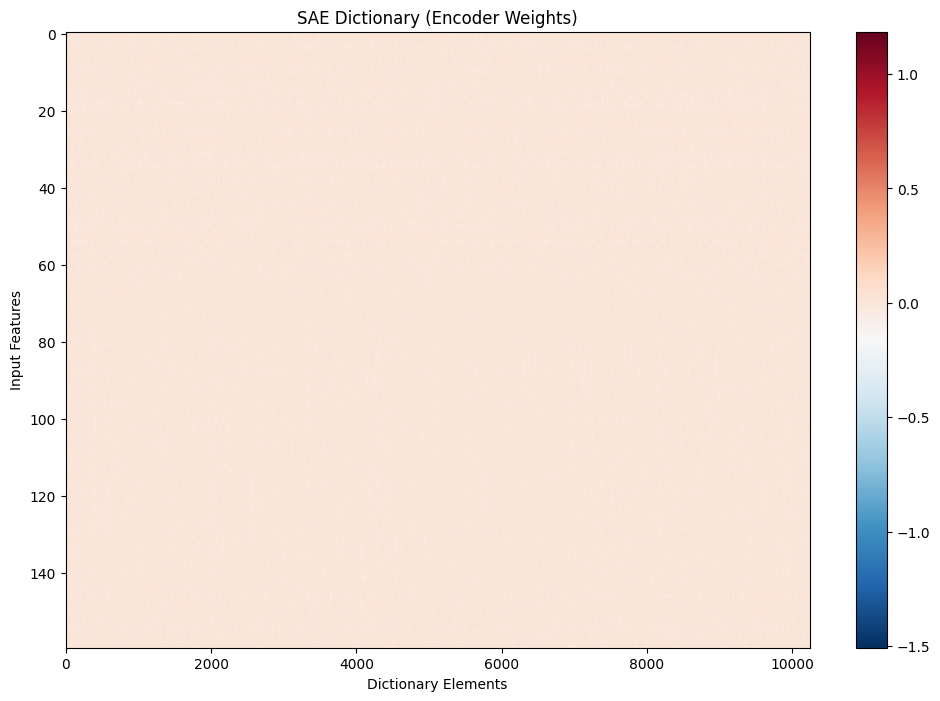

In [83]:
# Let's analyze the relationship between SAE activations and input features

# TODO(bschoen): Oh `imshow` is huge here!

# 1. Visualize the dictionary (encoder weights)
plt.figure(figsize=(12, 8))
plt.imshow(dictionary.cpu().T, aspect="auto", cmap="RdBu_r")
plt.colorbar()
plt.title("SAE Dictionary (Encoder Weights)")
plt.xlabel("Dictionary Elements")
plt.ylabel("Input Features")
plt.show()

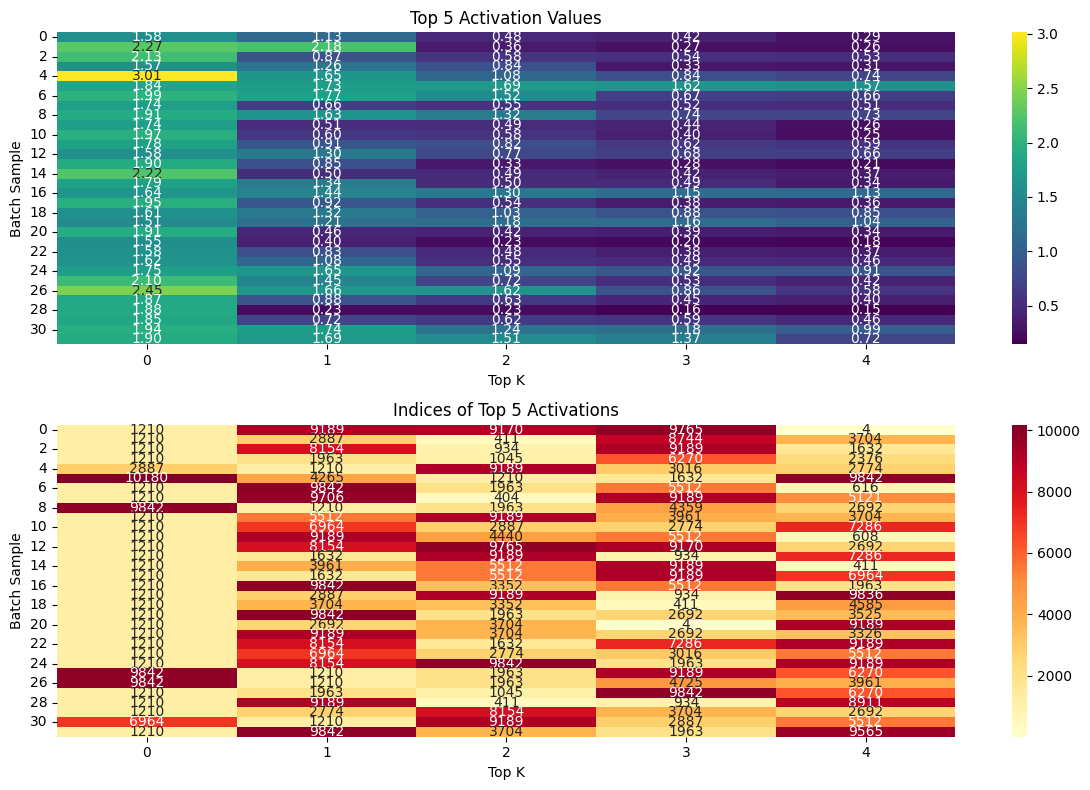

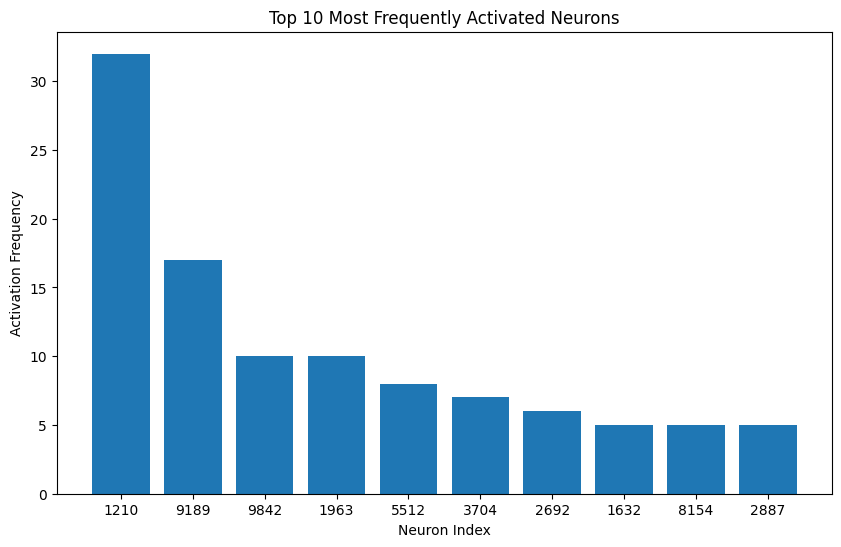

In [95]:
# 2. Find the most active neurons for each input
top_k = 5  # Number of top activations to consider

# so this is essentially the top 5 activations over `batch_size` examples
top_activations = torch.topk(sae_outputs.sae_activations, k=top_k, dim=1)

# Visualization of top activations
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
sns.heatmap(
    top_activations.values.detach().cpu().numpy(), cmap="viridis", annot=True, fmt=".2f"
)
plt.title("Top 5 Activation Values")
plt.xlabel("Top K")
plt.ylabel("Batch Sample")

plt.subplot(2, 1, 2)
sns.heatmap(
    top_activations.indices.detach().cpu().numpy(), cmap="YlOrRd", annot=True, fmt="d"
)
plt.title("Indices of Top 5 Activations")
plt.xlabel("Top K")
plt.ylabel("Batch Sample")

plt.tight_layout()
plt.show()

# Additional analysis: frequency of top neurons
top_neuron_counts = torch.bincount(
    top_activations.indices.flatten().detach().cpu(),
    minlength=sae_outputs.sae_activations.shape[1],
)
top_10_neurons = torch.topk(top_neuron_counts, k=10)

plt.figure(figsize=(10, 6))
plt.bar(range(10), top_10_neurons.values.detach().cpu().numpy())
plt.title("Top 10 Most Frequently Activated Neurons")
plt.xlabel("Neuron Index")
plt.ylabel("Activation Frequency")
plt.xticks(range(10), top_10_neurons.indices.detach().cpu().numpy())
plt.show()

In [101]:
sae_outputs.sae_activations[:, 1210]

tensor([1.5762, 2.2717, 2.1312, 1.5695, 1.6463, 1.6900, 1.9894, 1.7377, 1.6347,
        1.7378, 1.9690, 1.7829, 1.5791, 1.9022, 2.2202, 1.7898, 1.6406, 1.9504,
        1.6066, 1.5072, 1.9114, 1.5461, 1.5797, 1.6199, 1.7459, 1.4513, 1.6598,
        1.8661, 1.8778, 1.8486, 1.7351, 1.9002], device='mps:0',
       grad_fn=<SelectBackward0>)

In [90]:
print(f"{sae_outputs.sae_activations.shape=}")
print(f"{top_activations.values.shape=}")
print(f"{top_activations.indices.shape=}")

sae_outputs.sae_activations.shape=torch.Size([32, 10240])
top_activations.values.shape=torch.Size([32, 5])
top_activations.indices.shape=torch.Size([32, 5])


In [89]:
print(top_activations.indices)

tensor([[ 1210,  9189,  9170,  9765,     4],
        [ 1210,  2887,   411,  8744,  3704],
        [ 1210,  8154,   934,  9189,  1632],
        [ 1210,  1963,  1045,  6270,  2376],
        [ 2887,  1210,  9189,  3016,  2774],
        [10180,  4265,  1210,  1632,  9842],
        [ 1210,  9842,  1963,  5512,   616],
        [ 1210,  9706,   404,  9189,  5121],
        [ 9842,  1210,  1963,  4359,  2692],
        [ 1210,  5512,  9189,  3961,  3704],
        [ 1210,  6964,  2887,  2774,  7286],
        [ 1210,  9189,  4440,  5512,   608],
        [ 1210,  8154,  9765,  9170,  2692],
        [ 1210,  1632,  9189,   934,  7286],
        [ 1210,  3961,  5512,  9189,   411],
        [ 1210,  1632,  5512,  9189,  6964],
        [ 1210,  9842,  3352,  5512,  1963],
        [ 1210,  2887,  9189,   934,  9836],
        [ 1210,  3704,  3352,   411,  4585],
        [ 1210,  9842,  1963,  2692,  3525],
        [ 1210,  2692,  3704,     4,  9189],
        [ 1210,  9189,  3704,  2692,  3326],
        [ 

In [88]:
# ex: 51 and 410 show up a lot
sns.heatmap(top_activations.values.cpu().T, cmap="viridis")

torch.return_types.topk(
values=tensor([[1.5762, 1.1265, 0.4759, 0.4195, 0.2860],
        [2.2717, 2.1785, 0.3565, 0.2738, 0.2557],
        [2.1312, 0.8715, 0.5824, 0.5405, 0.5251],
        [1.5695, 1.2554, 0.8424, 0.3251, 0.3122],
        [3.0129, 1.6463, 1.0826, 0.8358, 0.7447],
        [1.8359, 1.7300, 1.6900, 1.6151, 1.5690],
        [1.9894, 1.7685, 1.5176, 0.6680, 0.6552],
        [1.7377, 0.6601, 0.5537, 0.5201, 0.5124],
        [1.9062, 1.6347, 1.3223, 0.7440, 0.7347],
        [1.7378, 0.5089, 0.4940, 0.4359, 0.2602],
        [1.9690, 0.6041, 0.5750, 0.4025, 0.2473],
        [1.7829, 0.9137, 0.8183, 0.6233, 0.5877],
        [1.5791, 1.3008, 0.7685, 0.6793, 0.6649],
        [1.9022, 0.8496, 0.3312, 0.2755, 0.2144],
        [2.2202, 0.5033, 0.4874, 0.4249, 0.3722],
        [1.7898, 1.3367, 0.4976, 0.4908, 0.3409],
        [1.6406, 1.4404, 1.3004, 1.1477, 1.1311],
        [1.9504, 0.9223, 0.5388, 0.3795, 0.3561],
        [1.6066, 1.3161, 1.0301, 0.8822, 0.8462],
        [1.5072, 1

In [84]:
# 3. Analyze feature importance for each neuron
feature_importance = torch.abs(dictionary).sum(dim=1)
top_features = torch.topk(feature_importance, k=10)

print(f"{dictionary.shape=}")
print(f"{feature_importance.shape=}")
print(f"{top_features.values.shape=}")
print(f"{top_features.indices.shape=}")

top_features

dictionary.shape=torch.Size([10240, 160])
feature_importance.shape=torch.Size([10240])
top_features.values.shape=torch.Size([10])
top_features.indices.shape=torch.Size([10])


torch.return_types.topk(
values=tensor([18.7362, 18.4388, 18.2695, 18.1503, 18.0190, 17.5335, 17.4631, 17.3934,
        17.1014, 17.0564], device='mps:0'),
indices=tensor([8763, 2887,  616, 8154, 7507, 6964, 4265, 2164, 3525, 9905],
       device='mps:0'))

In [64]:
print("\nTop 10 most important neurons:")
for i, (value, index) in enumerate(
    zip(top_features.values.tolist(), top_features.indices.tolist())
):
    print(f"Neuron {index}:\t{value:.4f}")


Top 10 most important neurons:
Neuron 586:	8.8380
Neuron 180:	8.6401
Neuron 327:	8.4845
Neuron 56:	8.4722
Neuron 60:	8.4699
Neuron 59:	8.4548
Neuron 122:	8.4195
Neuron 367:	8.4193
Neuron 261:	8.3852
Neuron 106:	8.3839


In [ ]:
top_features.values.tolist()

In [ ]:
top_features.indices.tolist()

sae_activations.shape=torch.Size([10240])


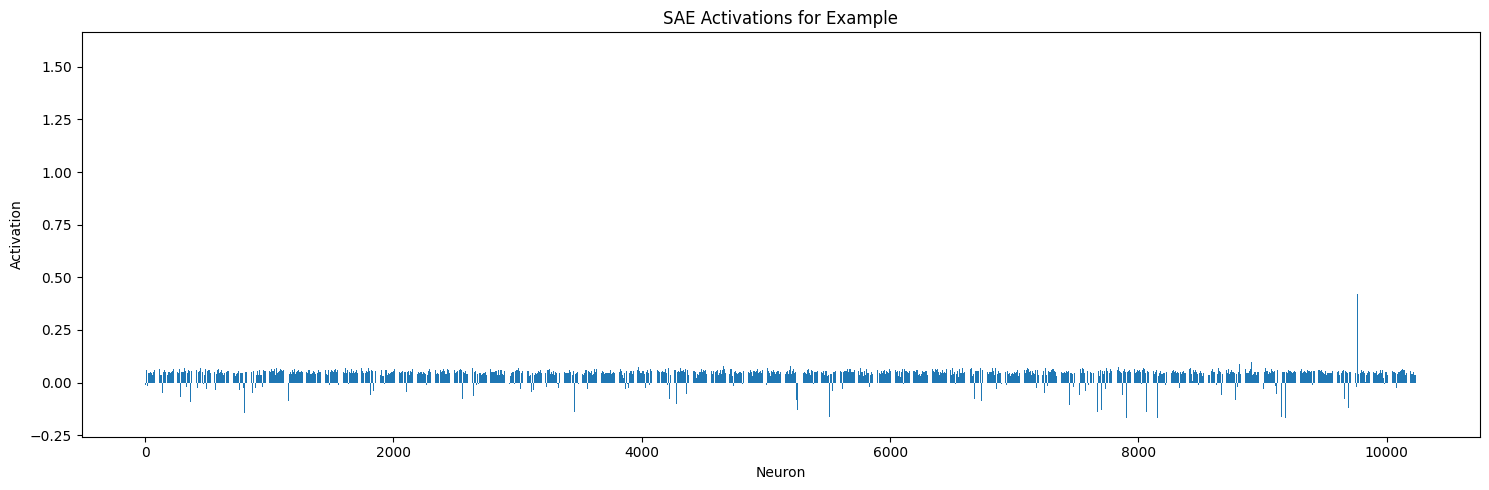

In [82]:
# 4. Visualize activations for a few examples

# first look at a single batch
sae_activations = sae_outputs.sae_activations[0].detach().cpu()

print(f"{sae_activations.shape=}")

plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)

# Look at a single batch
plt.bar(range(sae_activations.shape[0]), sae_activations)

plt.title(f"SAE Activations for Example")
plt.xlabel("Neuron")
plt.ylabel("Activation")
plt.tight_layout()
plt.show()

In [ ]:
# 5. Reconstruct input features from SAE activations
#
# Take a single batch first
reconstructed_model_activations = (
    sae_outputs.reconstructed_model_activations.detach().cpu()
)

# 6. Compare original and reconstructed features
num_features = 5

plt.figure(figsize=(15, 3 * num_features))
for i in range(num_features):
    plt.subplot(num_features, 1, i + 1)
    plt.ylim(-1, 1)  # Set y-axis range from -1 to 1
    plt.plot(flattened_activations[:, i].cpu(), label="Original", alpha=0.5)
    plt.plot(reconstructed_model_activations[:, i], label="Reconstructed", alpha=0.5)
    plt.title(f"Feature {i}: Original vs Reconstructed")
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 7. Correlation between SAE activations and input features
correlation_matrix = torch.corrcoef(
    torch.cat([sae_outputs.sae_activations, flattened_activations], dim=1).T
)
num_neurons = sae_outputs.sae_activations.shape[1]
neuron_feature_correlation = correlation_matrix[:num_neurons, num_neurons:]

plt.figure(figsize=(12, 8))
plt.imshow(
    neuron_feature_correlation.detach().cpu(),
    aspect="auto",
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
)
plt.colorbar()
plt.title("Correlation between SAE Neurons and Input Features")
plt.xlabel("Input Features")
plt.ylabel("SAE Neurons")
plt.show()

In [ ]:
sae_outputs.sae_activations

In [ ]:
# collect max activations


with torch.no_grad():

    # go through the training data again, but don't cycle, no reason to go through more than once
    for batch in tqdm.tqdm(train_loader):

        tokens, target = batch

        tokens, target = tokens.to(device), target.to(device)

        # run through the model (with cache) to get the activations
        logits, cache = model.run_with_cache(tokens)

        # ex: torch.Size([4, 8, 16])
        activations = cache[hook_id]

        # ex: torch.Size([4, 128])
        flattened_activations = activations.reshape(activations.size(0), -1)

        # now the SAE model is given the *activations*
        encoded, decoded = sae_model(flattened_activations)

        sae_activations = encoded

        # sae_activations.reshape(sae_d_model, (cfg.n_ctx - 1), cfg.d_model)

        # max_activations = torch.max(encoded, dim=1)

        break

In [ ]:
alpha = sae_model.encoder.weight @ flattened_activations[0]

print(f"{alpha.shape=}")

In [ ]:
torch.mean(torch.abs(alpha))

In [ ]:
sae_activations[0].shape

In [ ]:
8 * 16